<h1 div class='alert alert-success'><center> Ponto de partida (EDA)</center></h1>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

# <div class="alert alert-success">  OBJETIVO </div> 

Neste notebook vamos fazer uma análise (EDA) para conhencer os dados dos datasets e estabelecer uma linha de base, abaixo alguns tópico que vou abordar:

- variação por estação e dia da semana
- o efeito da Páscoa
- zoom no pico de fim de ano
- crescimento anual (que é maior para o pico de final de ano do que para o resto do ano)
- por que esta competição é pontuada pelo SMAP


---

# <div class="alert alert-success">  1. IMPORTAÇÕES </div> 

## 1.1. Instalações

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [2]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import holidays
import datetime

In [3]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import xgboost           as xgb
import scipy.stats       as stats
import statsmodels.api   as sm
import dateutil.easter   as easter

In [4]:
from sklearn.model_selection import train_test_split,  KFold, TimeSeriesSplit
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, power_transform
from sklearn.preprocessing   import PowerTransformer, RobustScaler, normalize
from sklearn.preprocessing   import MaxAbsScaler, QuantileTransformer, LabelEncoder
from sklearn                 import metrics
from sklearn.linear_model    import LinearRegression
from sklearn.compose         import TransformedTargetRegressor
from sklearn.model_selection import GroupKFold
from sklearn.linear_model    import LinearRegression, HuberRegressor, Ridge, Lasso

In [5]:
from datetime                import datetime
from pylab                   import rcParams
from matplotlib.ticker       import MaxNLocator, FormatStrFormatter, PercentFormatter

In [6]:
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import TimeSeriesSplit

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [7]:
def jupyter_setting():
    
    %matplotlib inline
      
    #os.environ["WANDB_SILENT"] = "true" 
    #plt.style.use('bmh') 
    #plt.rcParams['figure.figsize'] = [20,15]
    #plt.rcParams['font.size']      = 13
     
    pd.options.display.max_columns = None
    #pd.set_option('display.expand_frame_repr', False)

    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
    warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

    pd.set_option('display.max_rows', 200)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
          "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
          "lightskyblue", "sandybrown", "yellowgreen", "indianred",
          "lightsteelblue", "mediumorchid", "deepskyblue"]
    
    # Colors
    dark_red   = "#b20710"
    black      = "#221f1f"
    green      = "#009473"
    myred      = '#CD5C5C'
    myblue     = '#6495ED'
    mygreen    = '#90EE90'    
    color_cols = [myred, myblue,mygreen]
    
    return icecream, colors, color_cols

icecream, colors, color_cols = jupyter_setting()

In [8]:
def missing_zero_values_table(df):
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()

In [9]:
def reduce_memory_usage(df, verbose=True):
    
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    
    for col in df.columns:
        
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
        
    return df

In [10]:
def graf_label(ax, total):
    
     for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        width, height = i.get_width() -.2 , i.get_height()
        
        x, y  = i.get_xy()  
        color = 'white'
        alt   = .5
        soma  = 0 

        if height < 70:
            color = 'black'
            alt   = 1
            soma  = 10

        ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                    (i.get_x()+.3*width, 
                     i.get_y()+soma + alt*height),
                     color   = color,
                     weight = 'bold',
                     size   = 14)

In [11]:
def graf_bar(df, col, title, xlabel, ylabel, tol = 0):
    
    #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
    ax     = df    
    colors = col
    
    if tol == 0: 
        total  = sum(ax)
        ax = (ax).plot(kind    ='bar',
                       stacked = True,
                       width   = .5,
                       rot     = 0,
                       color   = colors, 
                       grid    = False)
    else:
        total  = tol     
        
        ax = (ax).plot(kind    ='bar',
                       stacked = True,
                       width   = .5,
                       rot     = 0,
                       figsize = (10,6),
                       color   = colors,
                       grid    = False)

    #ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    #y_fmt = tick.FormatStrFormatter('%.0f') 
    #ax.yaxis.set_major_formatter(y_fmt)

    title   = title #+ ' \n'
    xlabel  = '\n ' + xlabel 
    ylabel  = ylabel + ' \n'
    
    ax.set_title(title  , fontsize=22)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)    

    min = [0,23000000]
    #ax.set_ylim(min)
    
    graf_label(ax, total)

In [12]:
def smape(pred, obs):
    pred = np.array(pred)
    obs = np.array(obs)   
    return 100 * np.mean(2 * abs(pred-obs)/(abs(obs)+abs(pred)))

In [13]:
def smape_loss(y_true, y_pred):
    """SMAPE Loss"""
    return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200

In [14]:
def SMAPE(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [15]:
def calc_erro(y, y_pred, outros=True, ruturn_score=False):
    erro   = smape(y, y_pred)    
      
    
    if outros:        
        rmse = metrics.mean_squared_error(y, y_pred, squared=False)
        mape = metrics.mean_absolute_percentage_error(y, y_pred)
        mae  = metrics.mean_absolute_error(y, y_pred)
        
        print('RMSE : {:2.5f}'.format(rmse))
        print('MAE  : {:2.5f}'.format(mae))
        print('MAPE : {:2.5f}'.format(mape))
        
        
    if ruturn_score: 
        return erro
    else: 
        print('SMAPE: {:2.5f}'.format(erro))

In [16]:
def df_corr(df, annot_=False):
    
    df = df.corr(method ='pearson').round(5)

    # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
    mask = np.zeros_like(df)
    mask[np.triu_indices_from(mask)] = True

    # Making a plot
    plt.figure(figsize=(15,12))
    ax = sns.heatmap(df, annot=annot_, mask=mask, cmap="RdBu", annot_kws={"weight": "bold", "fontsize":13})

    ax.set_title("Mapa de calor de correlação das variável", fontsize=17)

    plt.setp(ax.get_xticklabels(), 
             rotation      = 90, 
             ha            = "right",
             rotation_mode = "anchor", 
             weight        = "normal")

    plt.setp(ax.get_yticklabels(), 
             weight        = "normal",
             rotation_mode = "anchor", 
             rotation      = 0, 
             ha            = "right");

In [17]:
def describe(df):
    var = df.columns

    # Medidas de tendência central, média e mediana 
    ct1 = pd.DataFrame(df[var].apply(np.mean)).T
    ct2 = pd.DataFrame(df[var].apply(np.median)).T

    # Dispensão - str, min , max range skew, kurtosis
    d1 = pd.DataFrame(df[var].apply(np.std)).T
    d2 = pd.DataFrame(df[var].apply(min)).T
    d3 = pd.DataFrame(df[var].apply(max)).T
    d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

    # concatenete 
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
    m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
    
    return m

In [18]:
def graf_outlier(df, feature):
    col = [(0,4), (5,9)]

    df_plot = ((df[feature] - df[feature].min())/
               (df[feature].max() - df[feature].min()))

    fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

    for i, (x) in enumerate(col): 
        sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

In [19]:
def diff(t_a, t_b):
    from dateutil.relativedelta import relativedelta
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [20]:
def free_gpu_cache():
    
    # https://www.kaggle.com/getting-started/140636
    #print("Initial GPU Usage")
    #gpu_usage()                             

    #cuda.select_device(0)
    #cuda.close()
    #cuda.select_device(0)   
    
    gc.collect()
    torch.cuda.empty_cache()

In [21]:
def graf_eval():

    results     = model.evals_result()
    ntree_limit = model.best_ntree_limit

    plt.figure(figsize=(20,7))

    for i, error in  enumerate(['mlogloss', 'merror']):#
        
        plt.subplot(1,2,i+1)
        plt.plot(results["validation_0"][error], label="Treinamento")
        plt.plot(results["validation_1"][error], label="Validação")

        plt.axvline(ntree_limit, 
                    color="gray", 
                    label="N. de árvore ideal {}".format(ntree_limit))
                    
        
        title_name ='\n' + error.upper() + ' PLOT \n'
        plt.title(title_name)
        plt.xlabel("Número de árvores")
        plt.ylabel(error)
        plt.legend();

In [22]:
#define the smape function
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

In [23]:
def linear_fit_slope(y):
    """Return the slope of a linear fit to a series."""
    y_pure = y.dropna()
    length = len(y_pure)
    x = np.arange(0, length)
    slope, intercept = np.polyfit(x, y_pure.values, deg=1)
    return slope

In [24]:
def linear_fit_intercept(y):
    """Return the intercept of a linear fit to a series."""
    y_pure = y.dropna()
    length = len(y_pure)
    x = np.arange(0, length)
    slope, intercept = np.polyfit(x, y_pure.values, deg=1)
    return intercept

## 1.4. Dataset

### 1.4.1. Descrição de dados

Para este desafio, temos informações de 1 anos de informações de vendas de três itens em duas lojas localizadas em três países diferentes, são dados completamente fictício, mas contém muitos efeitos que podemos ver em dados do mundo real, por exemplo: 
- efeito de fim de semanaç
- feriado;
- sazonalidade;
- etc;

O conjunto de dados é pequeno o suficiente para experimentar diversas abordagem de modelagem diferentes.

- Arquivos
    - train.csv - o conjunto de treinamento, que inclui os dados de vendas para cada combinação data-país-loja-item.
    - test.csv - o conjunto de teste; sua tarefa é prever as vendas de itens correspondentes para cada combinação de data-país-loja-item. Observe que a classificação Pública é pontuada no primeiro trimestre do ano de teste e a Privada no restante.
    - sample_submission.csv - um arquivo de envio de amostra no formato correto 


Variáveis do dataset:

- **row_id**: identificação da amostra;
- **date**: data da vendad do item; 
- **country**: cidade;  
- **store**: loja; 	
- **product**: produto; 
- **num_sold**: valor 


In [25]:
path   = '' # '/content/drive/MyDrive/kaggle/Tabular Playground Series/2021/12 - Dezembro/'
target = 'num_sold'

In [26]:
df1_train     = pd.read_csv(path + 'Data/train.csv')
df1_test      = pd.read_csv(path + 'Data/test.csv')
df_submission = pd.read_csv(path + 'Data/sample_submission.csv')

df1_train.shape, df1_test.shape, df_submission.shape

((70128, 6), (17520, 5), (17520, 2))

In [27]:
df1_train.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [46]:
df1_test.head()

,date,country,store,product
0,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


Vamos fazer a excluisaão da coluna row_id.

In [47]:
df1_train.drop('row_id', axis=1, inplace=True)
df1_test.drop('row_id', axis=1, inplace=True)

KeyError: "['row_id'] not found in axis"

### 1.3.1. Redução dos datasets

In [ ]:
df1_train = reduce_memory_usage(df1_train)
df1_test  = reduce_memory_usage(df1_test)

In [ ]:
df1_train.info()

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
Tivemos uma redução de 15% no dataset de treino.
    
</div>

# <div class="alert alert-success"> 2. Análise Exploratória de Dados (EDA)  </div> 

## 2.1. Dimensão do DataSet

In [ ]:
print('TREINO')
print('Número de linhas : {}'.format(df1_train.shape[0]))
print('Número de colunas: {}'.format(df1_train.shape[1]))
print('Primeiro dia     :', df1_train.date.min(), "   Último dia:", df1_train.date.max())
print("Número de dias em quatro anos:", 365 * 4 + 1, end='\n\n') # four years including one leap year

print('TESTE')
print('Número de linhas : {}'.format(df1_test.shape[0]))
print('Número de colunas: {}'.format(df1_test.shape[1]))
print('Primeiro dia     :', df1_test.date.min(), "   Último dia:", df1_test.date.max(), end='\n\n')

print(df1_train.groupby(['country', 'store', 'product']).date.count(), end='\n\n\n')

print('VENDA DOS PRODUTO')
print(df1_train.groupby(['country', 'store', 'product']).num_sold.agg(['min', 'max', 'mean']))

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
No resumo acima, temos três países, duas lojas e três produtos. Para todas as 18 combinações, temos os dados de vendas de 1461 dias, que são dos quatros anos (2015, 2016, 2017 e 2018), que serão utilizados para prever o ano de 2019 da base de teste, todos os produto são vendidos em todos os países e lojas.
    
    
</div>

## 2.2. Tipo de dados

In [48]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      70128 non-null  datetime64[ns]
 1   country   70128 non-null  object        
 2   store     70128 non-null  object        
 3   product   70128 non-null  object        
 4   num_sold  70128 non-null  int16         
dtypes: datetime64[ns](1), int16(1), object(3)
memory usage: 2.3+ MB


In [49]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      70128 non-null  datetime64[ns]
 1   country   70128 non-null  object        
 2   store     70128 non-null  object        
 3   product   70128 non-null  object        
 4   num_sold  70128 non-null  int16         
dtypes: datetime64[ns](1), int16(1), object(3)
memory usage: 2.3+ MB


In [50]:
print(f'{3*"="} For Pandas {10*"="}\n{(df1_train.dtypes).value_counts()}')
print(f'\n{3*"="} For Datatable {7*"="}\n{(df1_test.dtypes).value_counts()}')

=== For Pandas ==========
object            3
datetime64[ns]    1
int16             1
dtype: int64

=== For Datatable =======
object            3
datetime64[ns]    1
dtype: int64



<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>

Vamos transformar a variável **date** em data, pois estamos trabalhando com dados dependete de temporariedade (serie temporal), onde o tempo é fundamental para as previsões, pois podemos identificar sazonanaridade, finais de semana, feriados e outros eventos relacionados ao tempo. 
    
</div>

In [51]:
df1_train.date  = df1_train['date'].astype(np.datetime64)
df1_test.date   = df1_test['date'].astype(np.datetime64)

In [52]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      70128 non-null  datetime64[ns]
 1   country   70128 non-null  object        
 2   store     70128 non-null  object        
 3   product   70128 non-null  object        
 4   num_sold  70128 non-null  int16         
dtypes: datetime64[ns](1), int16(1), object(3)
memory usage: 2.3+ MB


## 2.3. Identificar NA

In [53]:
missing = missing_zero_values_table(df1_train)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 5 colunas e 70128 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


In [54]:
missing = missing_zero_values_table(df1_test)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 4 colunas e 17520 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>

Não temos dados faltantes nos datasets.
    
</div>

## 2.4 Estatística Descritiva
Abaixo estão as estatísticas básicas para cada variável que contém informações sobre contagem, média, desvio padrão, mínimo, 1º quartil, mediana, 3º quartil e máximo.

### 2.4.1 Atributos numéricos

- Train

In [55]:
df1_train.describe()

,num_sold
count,70128.000000
mean,194.296986
std,126.893874
min,19.000000
25%,95.000000
50%,148.000000
75%,283.000000
max,986.000000


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>

Olhando para o valor de 387 de média e a 315 de mediana, identificamos que a variável **num_sold** tem uma distribuição assimétrica a direita, com desvio padrão de 266 podemos considerá-lo muito alto, uma transformação nesta variável pode melhorar a assimetria e consequentemente ajudar nas previsões, não temos valores negativos para a variável **num_sold**.
    
Vamos fazer a estatística de cada cidade/loja/produto.
    
</div>

In [56]:
i = 1 

for country in df1_train['country'].unique():        
    filtro_country = (df1_train['country']==country)    
    for store in df1_train[filtro_country]['store'].unique():          
        df_products = df1_train[(df1_train['country']==country) & (df1_train['store']==store)]         
        for product in df_products['product'].unique():             
            df_product = df_products[df_products['product']==product]
            print('{} / {} / {}'.format(country, store, product))
            print(df_product.describe(), end='\n \n')
            i +=1 

Belgium / KaggleMart / Kaggle Advanced Techniques
          num_sold
count  1461.000000
mean    405.895962
std      83.372642
min     252.000000
25%     340.000000
50%     396.000000
75%     458.000000
max     878.000000
 
Belgium / KaggleMart / Kaggle Getting Started
          num_sold
count  1461.000000
mean    325.649555
std      59.598247
min     172.000000
25%     286.000000
50%     325.000000
75%     359.000000
max     688.000000
 
Belgium / KaggleMart / Kaggle Recipe Book
          num_sold
count  1461.000000
mean    243.922656
std      43.539765
min     146.000000
25%     216.000000
50%     240.000000
75%     264.000000
max     581.000000
 
Belgium / KaggleMart / Kaggle for Kids: One Smart Goose
          num_sold
count  1461.000000
mean    437.316222
std      62.922718
min     278.000000
25%     397.000000
50%     427.000000
75%     469.000000
max     925.000000
 
Belgium / KaggleRama / Kaggle Advanced Techniques
          num_sold
count  1461.000000
mean    140.880219
std    

Spain / KaggleRama / Kaggle Advanced Techniques
          num_sold
count  1461.000000
mean    101.333333
std      25.212884
min      56.000000
25%      82.000000
50%      99.000000
75%     116.000000
max     234.000000
 
Spain / KaggleRama / Kaggle Getting Started
          num_sold
count  1461.000000
mean     81.130732
std      20.087139
min      47.000000
25%      67.000000
50%      77.000000
75%      89.000000
max     182.000000
 
Spain / KaggleRama / Kaggle Recipe Book
          num_sold
count  1461.000000
mean     60.702943
std      15.069135
min      38.000000
25%      51.000000
50%      57.000000
75%      67.000000
max     157.000000
 
Spain / KaggleRama / Kaggle for Kids: One Smart Goose
          num_sold
count  1461.000000
mean    109.705681
std      24.886612
min      76.000000
25%      92.000000
50%     102.000000
75%     123.000000
max     242.000000
 


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
 
- Primeiro ponto a destacar é que temos 1461 linhas para cada produto; 
- Temos produto que tem desvio padrão muito alto com **Finland / KaggleRama / Kaggle Hat** com desvio de 165.58, isso pode ser justificado pelos valores que extremos (outliers), que também aumenta a média, mais à frente vamos fazer uma análise com o box-plot; 
    
- Outro ponto a destacar em relação ao valores extremos, pode ser efeito de sazonalidade.  
    

Abaixo um exemplo quando removemos os valores extremo do produto **Finland / KaggleRama / Kaggle Hat**.
    
</div>

In [117]:
df_products = df1_train[(df1_train['country']=='Finland') & \
                        (df1_train['store']=='KaggleRama') & \
                        (df1_train['product']=='Kaggle Hat')] 

superior      = df_products[target].quantile(0.85)
inferior      = df_products[target].quantile(0.05)

superior , inferior
df_products[(df_products.num_sold>inferior) & (df_products.num_sold <superior) ].describe()

,num_sold
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


---

## 2.6. Distribuição

### 2.6.1. Train / Test

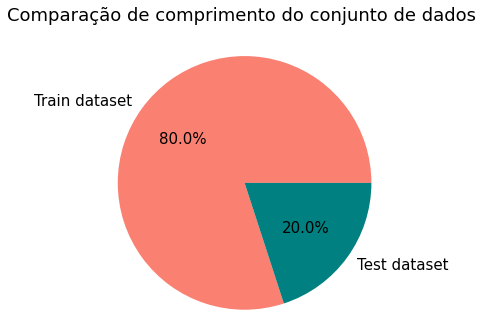

In [118]:
fig, ax = plt.subplots(figsize=(5, 5))

pie = ax.pie([len(df1_train), len(df1_test)],
             labels   = ["Train dataset", "Test dataset"],
             colors   = ["salmon", "teal"],
             textprops= {"fontsize": 15},
             autopct  = '%1.1f%%')

ax.axis("equal")
ax.set_title("Comparação de comprimento do conjunto de dados \n", fontsize=18)
fig.set_facecolor('white')
plt.show();

---

### 2.6.2. Distribuição da target

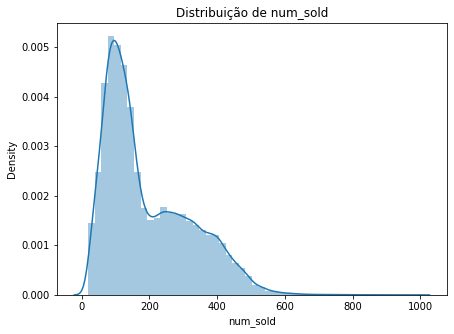

In [119]:
plt.figure(figsize=(7,5))
plt.title("Distribuição de num_sold")
ax = sns.distplot(df1_train[target])

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
Observando o gráfico acima da nossa variável **num_sold**, notamos que a distribuição dos dados não são normalmente distribuidos, segue uma distribuição assimétrica positiva com outliners, uma sugestão é fazer uma normalização de log ou raiz quadrada, pode ajuda a resuzir a assemetria, vamos fazer a essas duas normalizações.
    
</div>

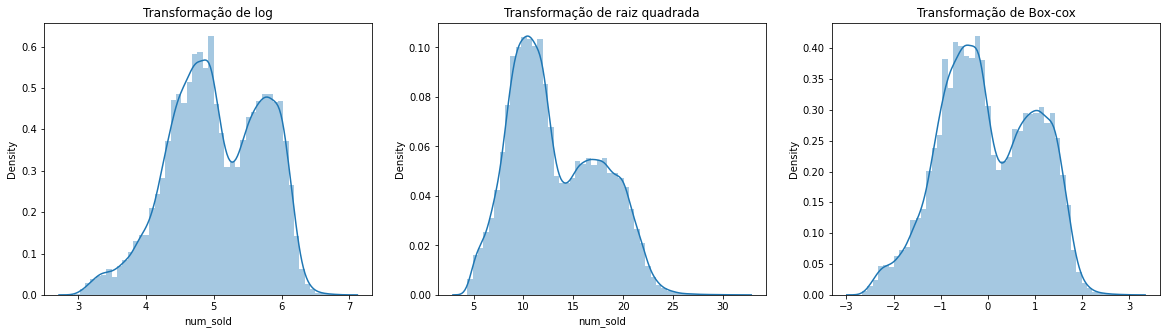

In [120]:
plt.figure(figsize=(20,5))
plt.title("Distribuição de num_sold")

power = PowerTransformer(method='box-cox', standardize=True) 

num_sold     = df1_train[target]
num_sold_log = np.log(num_sold)
num_sold_sqr = np.sqrt(num_sold)
num_sold_box = power.fit_transform(pd.DataFrame(num_sold))

plt.subplot(1,3,1)
ax = sns.distplot(num_sold_log)
plt.title("Transformação de log")

plt.subplot(1,3,2)
ax = sns.distplot(num_sold_sqr)
plt.title("Transformação de raiz quadrada");

plt.subplot(1,3,3)
ax = sns.distplot(num_sold_box)
plt.title("Transformação de Box-cox");

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
Nos gráficos acima, podemos observar que a transformação de log deu uma deslocada para a direita,    deixou os dados mais próximos de uma distribuição normal, a transformação de raiz quadrada permanece com os dados com assimetria positiva e na transformação de box-cox temos valroes negativos, mas tem uma visualização de uma distribuição normal
    
    
Vamos fazer um teste de normalidade para a transformação de log, neste caso vamos utilizar o teste de Shapiro, é importante entender as hipótese que são:
- **A Hipótese Nula (H0)**: se o p-value > que o nível de significância, então a distribuição é normalç
- **A Hipótese Alternativa (H1)**: se o p value < menor que o nível de significância, então a distribuição não é normal.

Observação: o nível de significância é de 0.05.
                                                       
</div>

In [121]:
shapiro_stat, shapiro_p_valor = stats.shapiro(num_sold_log)

print('P-value  : {:2.5}'.format(shapiro_p_valor))
print('Statistic: {:2.5}'.format(shapiro_stat))
print()

if shapiro_p_valor > 0.05:
    print("Com 95% de confiança, os dados são similares a uma distribuição normal")
else:
    print("Com 95% de confiança, os dados não são similares a uma distribuição normal")

P-value  : 0.0
Statistic: 0.98

Com 95% de confiança, os dados não são similares a uma distribuição normal


- **<p style='font-size:18px'> Store</p>**

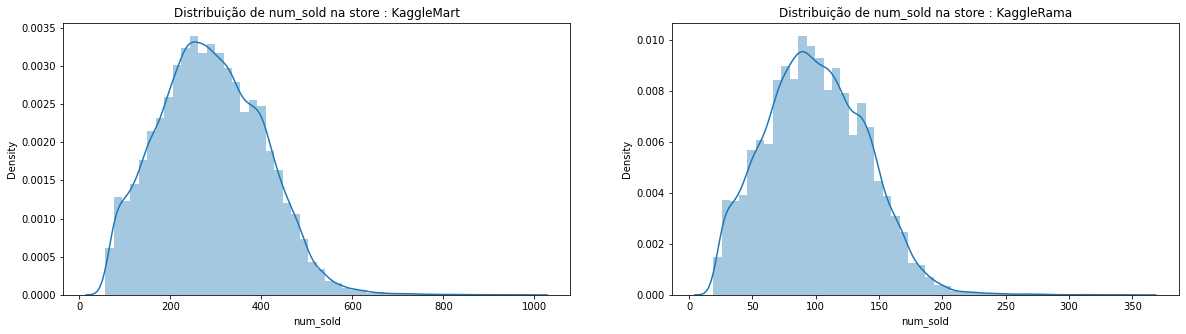

In [122]:
plt.figure(figsize=(20,5))
for i, store in enumerate(df1_train.store.unique()):    
    plt.subplot(1,2,i+1)
    plt.title("Distribuição de num_sold na store : {}".format(store))
    ax = sns.distplot(df1_train[df1_train['store']==store][target])

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
Notamos no gráfico acima que a filial **KaggleMart** tem o maior volume de vendas, com valor máximo de  1750 e a loja **KaggleRoma** com menor volume de venda, porém com valor máximo que pode chegar a  3000, pode ser um indicativo que a variável **store** pode ser de alta relevancia na modelagem. 
    
</div>

- **<p style='font-size:18px'> Product</p>**

0
1
2
3


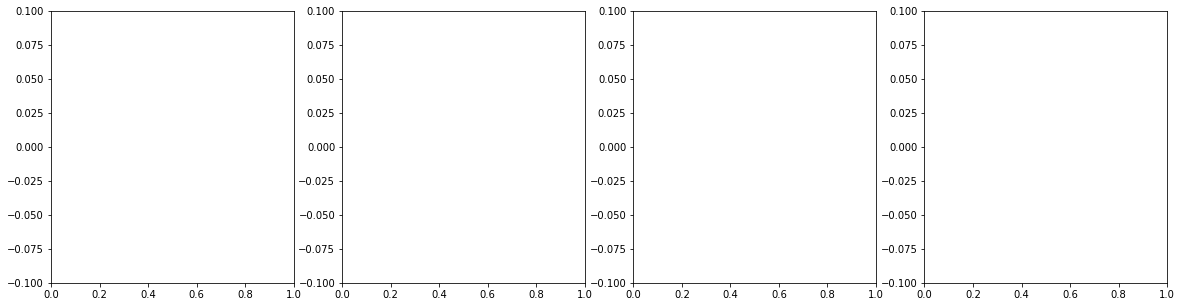

In [129]:
plt.figure(figsize=(20,5))
      
for c, product in enumerate(df1_train['product'].unique()):
    df_aux = df1_train[(df1_train['product']==product)]
    plt.subplot(1,4,c+1,  ymargin=0.5)
    print(c)

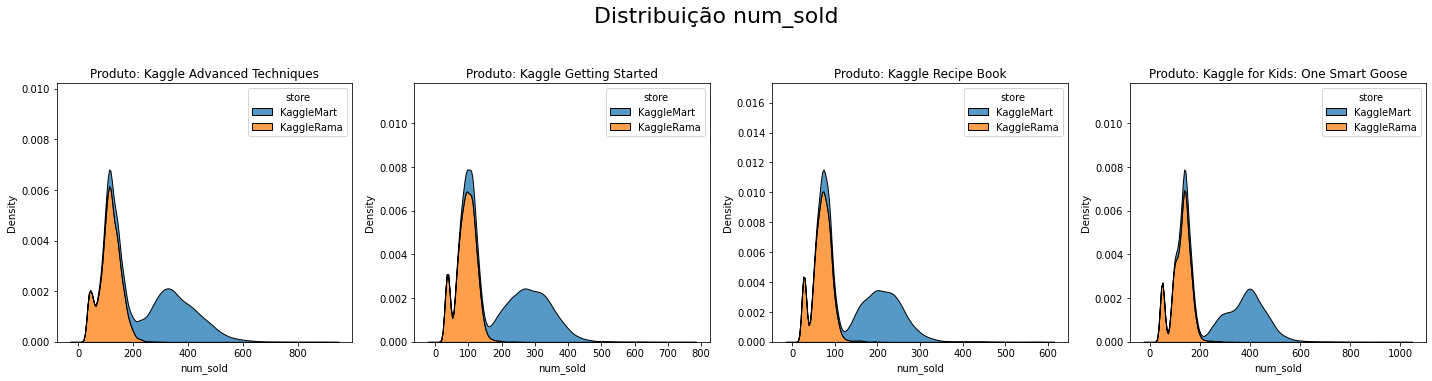

In [130]:
plt.figure(figsize=(20,5))
      
for c, product in enumerate(df1_train['product'].unique()):
    df_aux = df1_train[(df1_train['product']==product)]
    plt.subplot(1,4,c+1,  ymargin=0.5)
    plt.title("Produto: {}".format(product))
    ax = sns.kdeplot(data     = df_aux,
                     x        = target, 
                     hue      = 'store',
                     multiple = 'stack', 
                     legend   = True, 
                     shade    = True )    
    
    c+=1
    
plt.suptitle('Distribuição num_sold', y=1.05, fontsize=22);
plt.tight_layout(h_pad=3.0);

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Observando os gráficos acima, constatamos que os produtos tem a mesma distribuição em ambas lojas, porém a loja **KaggleRama** tem o volume de venda menor que a loja **KaggleMart**, vamos fazer o gráfico de histograma para cada combinação. 
    
</div>

In [131]:
df1_train.groupby(['country', 'store', 'product'])

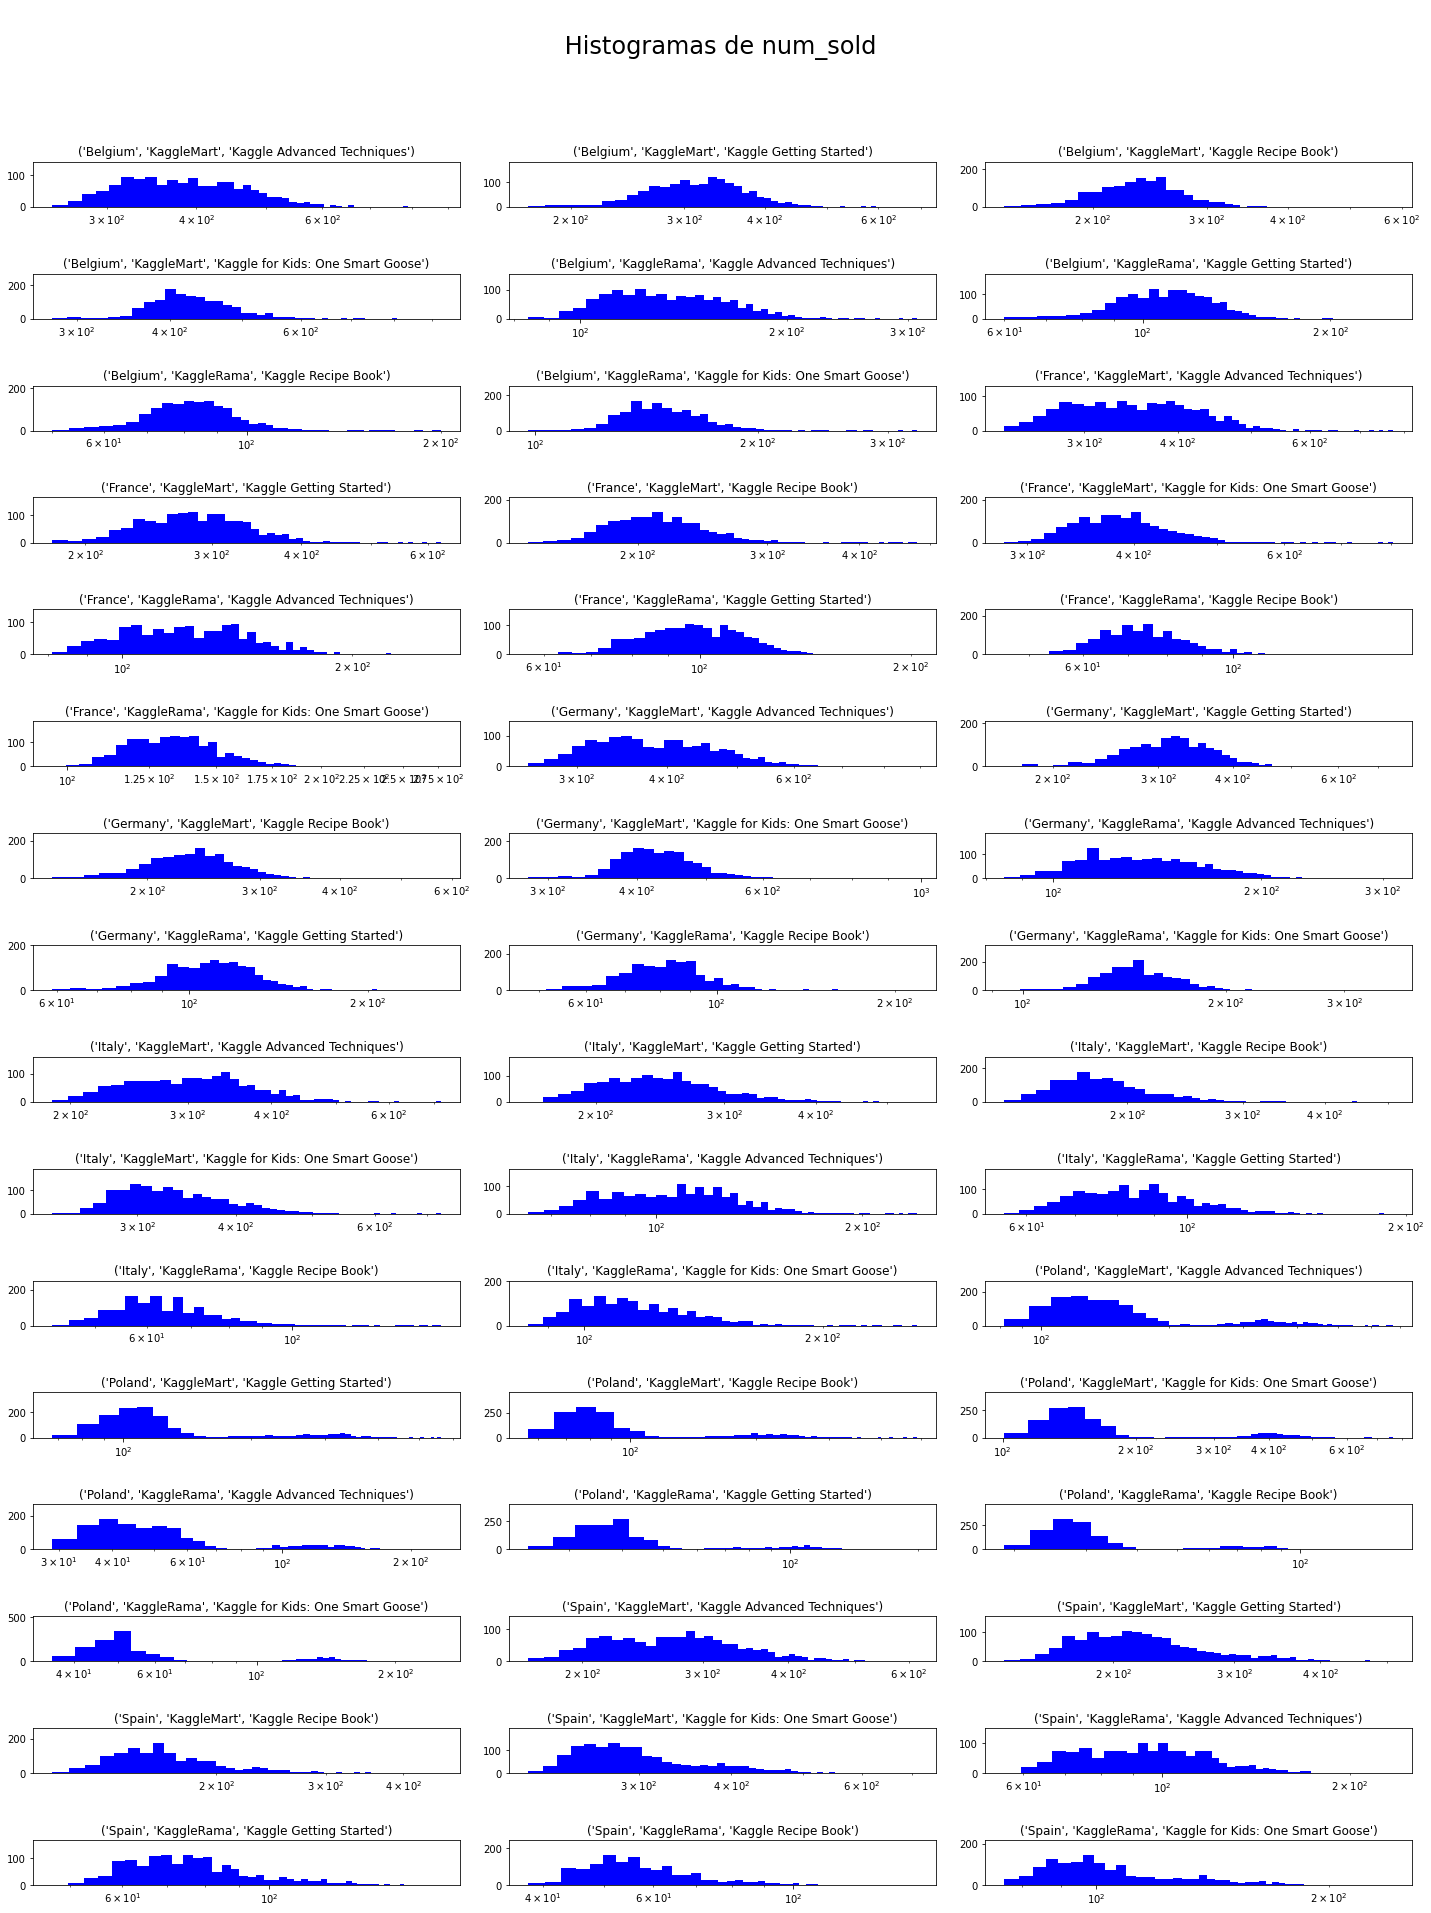

In [135]:
plt.figure(figsize=(20, 30))

for i, (combi, df) in enumerate(df1_train.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(19, 3, i+1, ymargin=0.5)
    ax.hist(df.num_sold, bins=50, color='blue')
    ax.set_xscale('log')
    ax.set_title(combi)
    
plt.suptitle('\n Histogramas de num_sold', y=1.03 , fontsize=24)
plt.tight_layout(h_pad=3.0)
plt.show()

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>

Os histogramas para cada combinação país-loja-produto mostram que todos os histogramas são distorcidos. Para cada produto, há alguns dias com vendas muito acima da média. Para esses valores discrepantes, as previsões serão muito menos precisas do que para os dias normais. É por isso que a competição é pontuada por erro percentual absoluto médio simétrico ([SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error)) em vez de MAE ou MSE.

Claro, em uma competição pontuada pelo SMAP, temos que escolher cuidadosamente uma função de perda para treinar nossos modelos. MSE ou MAE não são as funções de perda ideais aqui.

O histograma de cada produto tem uma forma ligeiramente diferente. Os histogramas do **Kaggle Hat** parecem mais amplos do que os histogramas dos outros dois produtos.

**Observações**
- A escolha de uma função de perda adequada é importante.
- Pode ser vantajoso prever log(num_sold) em vez de num_sold diretamente.
- Precisamos de mais análises para entender por que os histogramas têm formas diferentes. Talvez seja por causa das variações sazonais, talvez haja algo mais.

</div>

## 2.7. Detecção de Outlier

- **<p style='font-size:18px'> Store</p>**

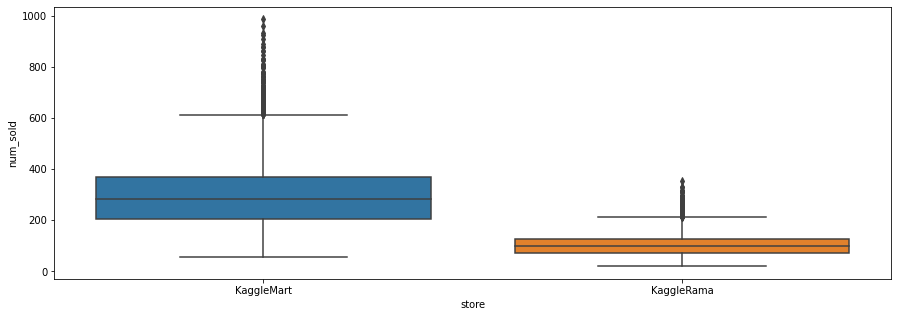

In [136]:
plt.figure(figsize=(15,5))
sns.boxplot(x='store', y=target, data= df1_train);

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
Notamos que ambas as lojas tem muitos outliers e que as medianas são diferentes, vamos dar uma olhada nos produtos, vamos box-plot a nível de produto. 
    
</div>

- **<p style='font-size:18px'> Country / Store / Product</p>**

ValueError: num must be 1 <= num <= 18, not 19

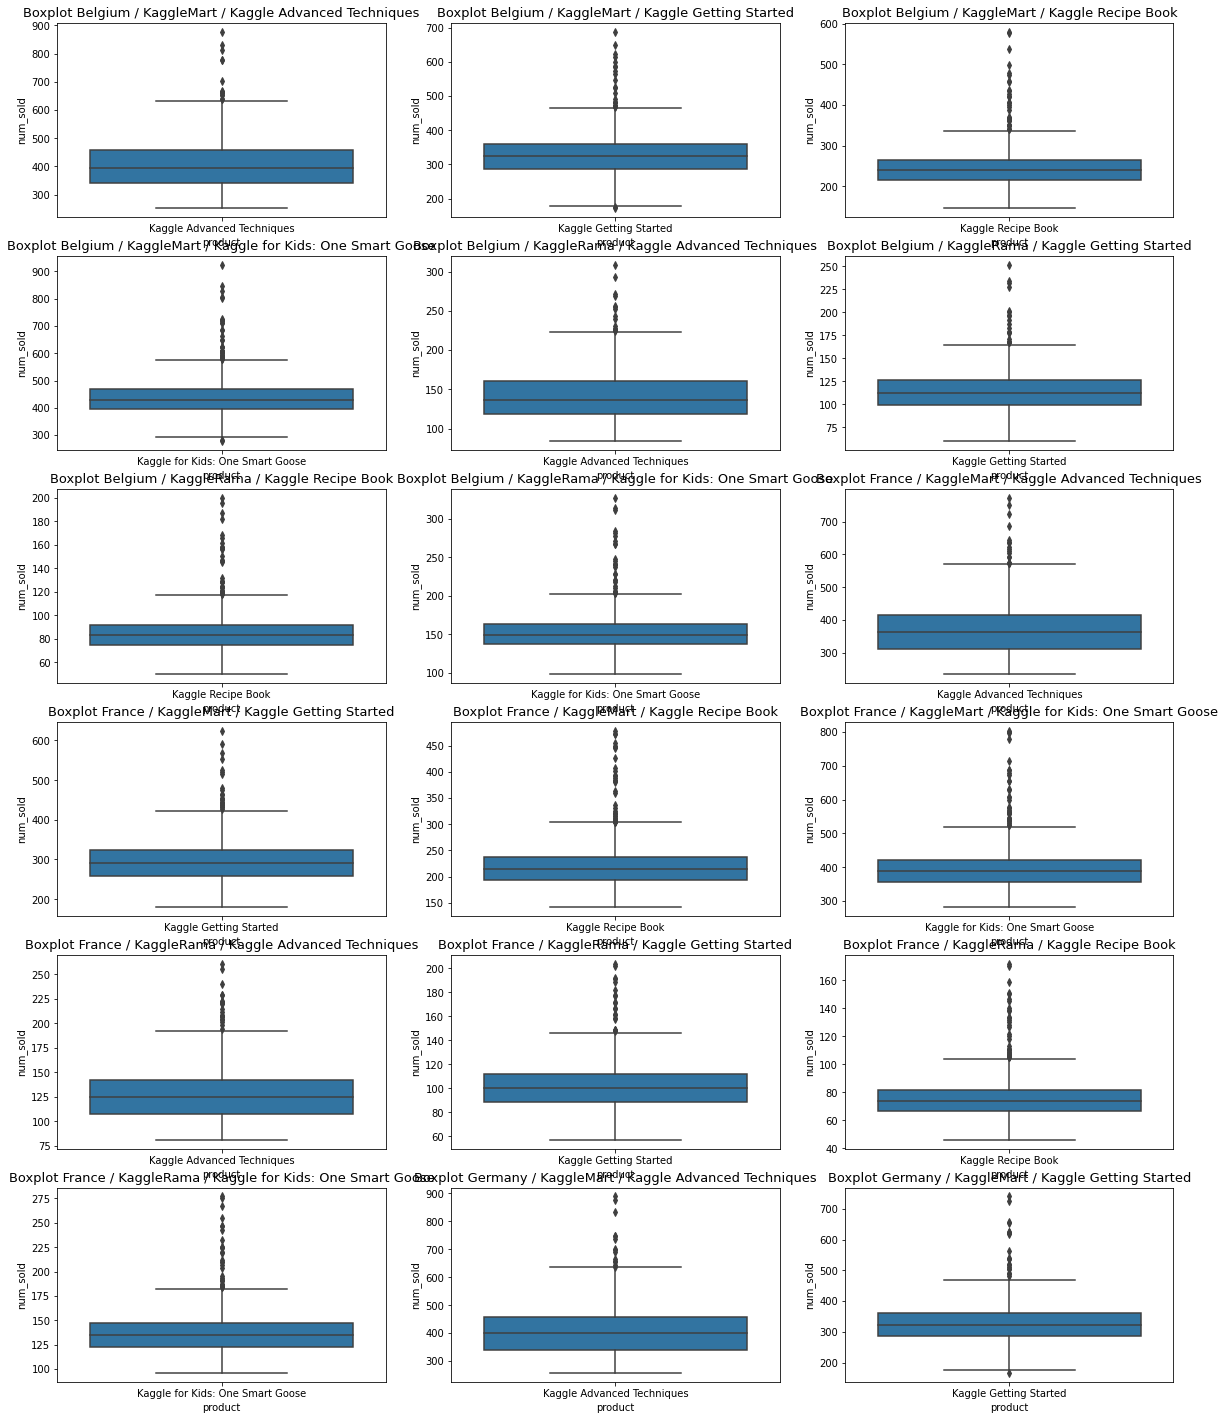

In [66]:
plt.figure(figsize=(20,25))

i = 1 

for country in df1_train['country'].unique():        
    filtro_country = (df1_train['country']==country)
    
    for store in df1_train[filtro_country]['store'].unique():          
        df_products = df1_train[(df1_train['country']==country) & (df1_train['store']==store)] 
        
        for product in df_products['product'].unique():             
            df_product = df_products[df_products['product']==product]     
            plt.subplot(6, 3, i);
            plt.title('Boxplot {} / {} / {}'.format(country, store, product), loc="center", fontsize=13);
            sns.boxplot(x='product', y=target, data=df_product);
            
            i +=1        
            
plt.suptitle('\n\n Análise de outlirs', y=1.03, fontsize=24);
plt.tight_layout(h_pad=3.0);

del df_product, df_products, filtro_country

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
 
Notamos nos gráficos acima, que temos muitos outlirs em todos os produto, provavelmente isso ocorre por motivo do aumento das vendas em determinadas épocas, isso é, sazonalidade. 
    
Um ponto importante a destacar, é estrutura individualizada do produto, isso é um indicativo que temos capturar essa individualização com a criação de variáveis, mais à frente vamos identicar os padrões de sazonalidade. 

    
</div>

---

## 2.8. Análise dos dados 


### 2.8.1. País

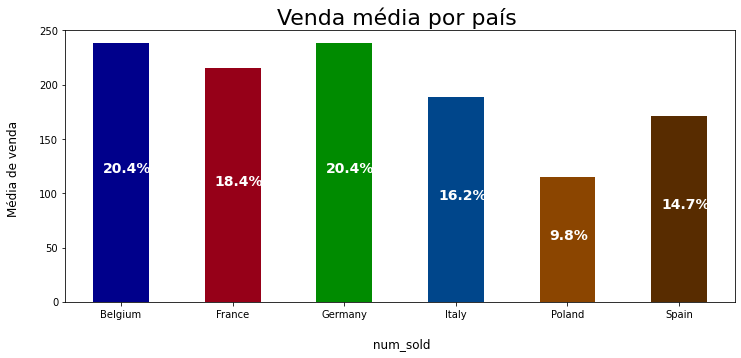

In [71]:
plt.figure(figsize=(12,5))  
graf_bar(df1_train.groupby(['country'])['num_sold'].mean(), 
         icecream, 
         'Venda média por país ', 
         'num_sold', 
         'Média de venda');

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
Observando o gráficoa, a Noruega vende mais que os outros dois países. 
    
</div>

### 2.8.1. País / Loja / Produto

ValueError: num must be 1 <= num <= 6, not 7

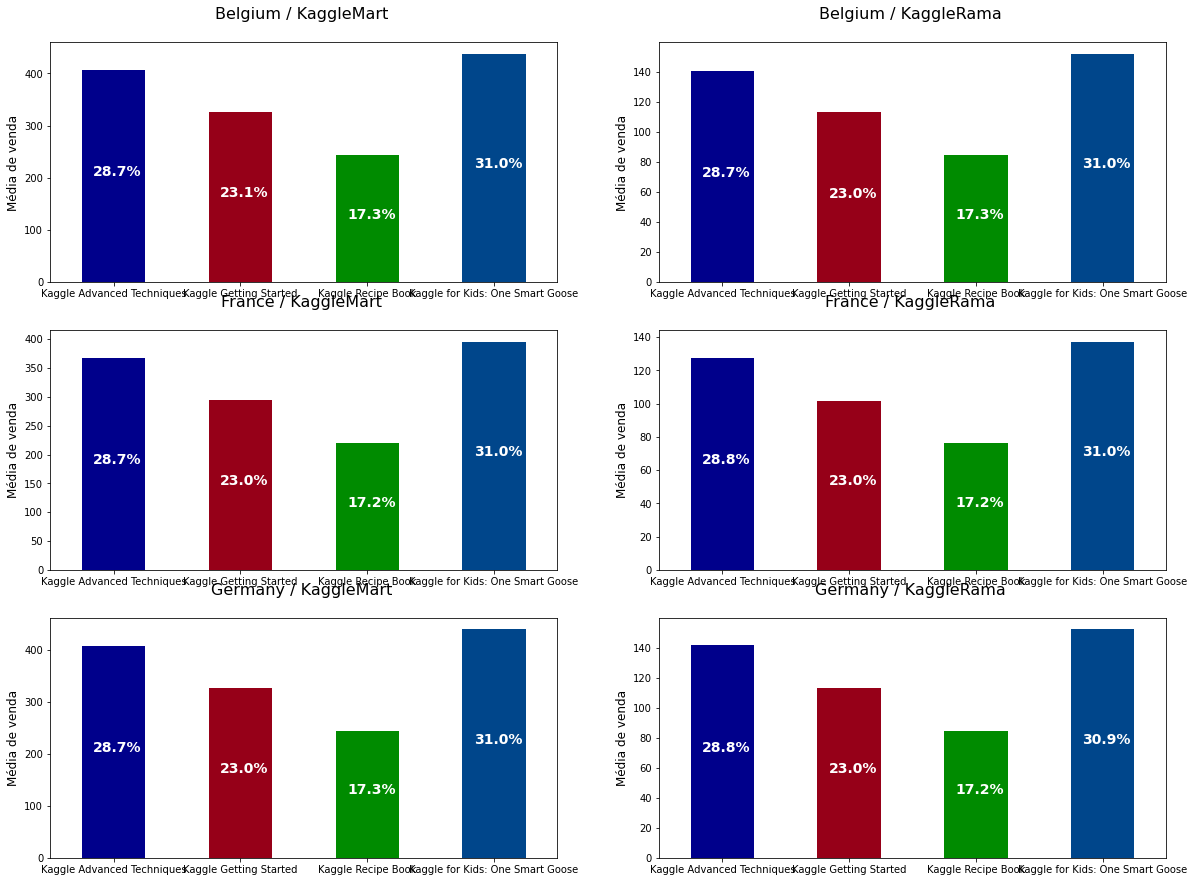

In [72]:
#plt.figure(figsize=(20,30))

i = 1 

for country in df1_train['country'].unique():        
    filtro_country = (df1_train['country']==country)
    
    for store in df1_train[filtro_country]['store'].unique():  
        
        ax = df1_train[(df1_train['country']==country) & (df1_train['store']==store)]. \
             groupby([ 'product'])['num_sold'].mean() 
        
        plt.subplot(3, 2, i);
        total  = sum(ax)
        ax     = ax.plot(kind    ='bar', 
                         stacked = True,
                         width   = .5,
                         rot     = 0,
                         color   = icecream, 
                         grid    = False, 
                         figsize=(20,15)
                        )
            
        ax.set_title('{} / {}'.format(country, store) +' \n', fontsize=16)
        ax.set_xlabel('', fontsize=12)
        ax.set_ylabel('Média de venda', fontsize=12)  
        graf_label(ax, total)

        i +=1        
            
plt.suptitle('\n Análise de venda por País / Loja / Produto', y=1.03, fontsize=24);
plt.tight_layout(h_pad=3.0);

del ax

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Observado os gráficos acima a loja **KaggleRama** vende mais em cada país e produto e a Noruega confima venda mais em todos os aspectos, vamos ver quanto mais é vendido por **Kaggle Rama**. 
    
    
</div>

In [73]:
df = df1_train.groupby(['country', 'store', 'product']).num_sold.mean().unstack(level='store')
df['KaggleRama:KaggleMart'] = df.KaggleRama / df.KaggleMart
display(df)

del df

store                                     KaggleMart  KaggleRama  \
country product                                                    
Belgium Kaggle Advanced Techniques        405.895962  140.880219   
        Kaggle Getting Started            325.649555  113.041068   
        Kaggle Recipe Book                243.922656   84.738535   
        Kaggle for Kids: One Smart Goose  437.316222  152.080767   
France  Kaggle Advanced Techniques        366.978097  127.389459   
        Kaggle Getting Started            294.089665  101.869268   
        Kaggle Recipe Book                220.158795   76.188912   
        Kaggle for Kids: One Smart Goose  395.650240  137.264203   
Germany Kaggle Advanced Techniques        406.429158  141.444216   
        Kaggle Getting Started            325.702259  113.268309   
        Kaggle Recipe Book                244.533881   84.728268   
        Kaggle for Kids: One Smart Goose  439.027379  152.063655   
Italy   Kaggle Advanced Techniques        321.937029  111.344969   
        Kaggle Getting Started            257.516769   89.260096   
        Kaggle Recipe Book                192.754278   66.808350   
        Kaggle for Kids: One Smart Goose  346.918549  120.025325   
Poland  Kaggle Advanced Techniques        195.466119   67.574264   
        Kaggle Getting Started            156.626283   54.306639   
        Kaggle Recipe Book                117.302533   40.559890   
        Kaggle for Kids: One Smart Goose  212.738535   73.663244   
Spain   Kaggle Advanced Techniques        292.252567  101.333333   
        Kaggle Getting Started            234.632444   81.130732   
        Kaggle Recipe Book                175.963039   60.702943   
        Kaggle for Kids: One Smart Goose  315.420945  109.705681   

store                                     KaggleRama:KaggleMart  
country product                                                  
Belgium Kaggle Advanced Techniques                     0.347085  
        Kaggle Getting Started                         0.347125  
        Kaggle Recipe Book                             0.347399  
        Kaggle for Kids: One Smart Goose               0.347759  
France  Kaggle Advanced Techniques                     0.347131  
        Kaggle Getting Started                         0.346388  
        Kaggle Recipe Book                             0.346063  
        Kaggle for Kids: One Smart Goose               0.346933  
Germany Kaggle Advanced Techniques                     0.348017  
        Kaggle Getting Started                         0.347766  
        Kaggle Recipe Book                             0.346489  
        Kaggle for Kids: One Smart Goose               0.346365  
Italy   Kaggle Advanced Techniques                     0.345859  
        Kaggle Getting Started                         0.346619  
        Kaggle Recipe Book                             0.346599  
        Kaggle for Kids: One Smart Goose               0.345976  
Poland  Kaggle Advanced Techniques                     0.345708  
        Kaggle Getting Started                         0.346727  
        Kaggle Recipe Book                             0.345772  
        Kaggle for Kids: One Smart Goose               0.346262  
Spain   Kaggle Advanced Techniques                     0.346732  
        Kaggle Getting Started                         0.345778  
        Kaggle Recipe Book                             0.344976  
        Kaggle for Kids: One Smart Goose               0.347807

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
Para cada país e produto, o **KaggleRama** vende em média 1,74 vezes mais do que o KaggleMart.

**Observação:** 
Talvez seja suficiente modelar o **Kaggle Mart** e multiplicar todas as previsões por 1,74 para obter as previsões do **Kaggle Rama**.
    
    
    
</div>

---

## 2.9. Análise de Séries Temporais
Nesta etapa do processo de análise, como estamos trabalhando com dados temporais, vamos fazer algumas análise dos dados em relação ao tempo (dia, semana, mes, ano, feriado, etc), com o intuito de identificarmos alguns padrões como: sazonalidade, clico e tendência. 

### 2.9.1. Vendas diárias e pico de final de ano



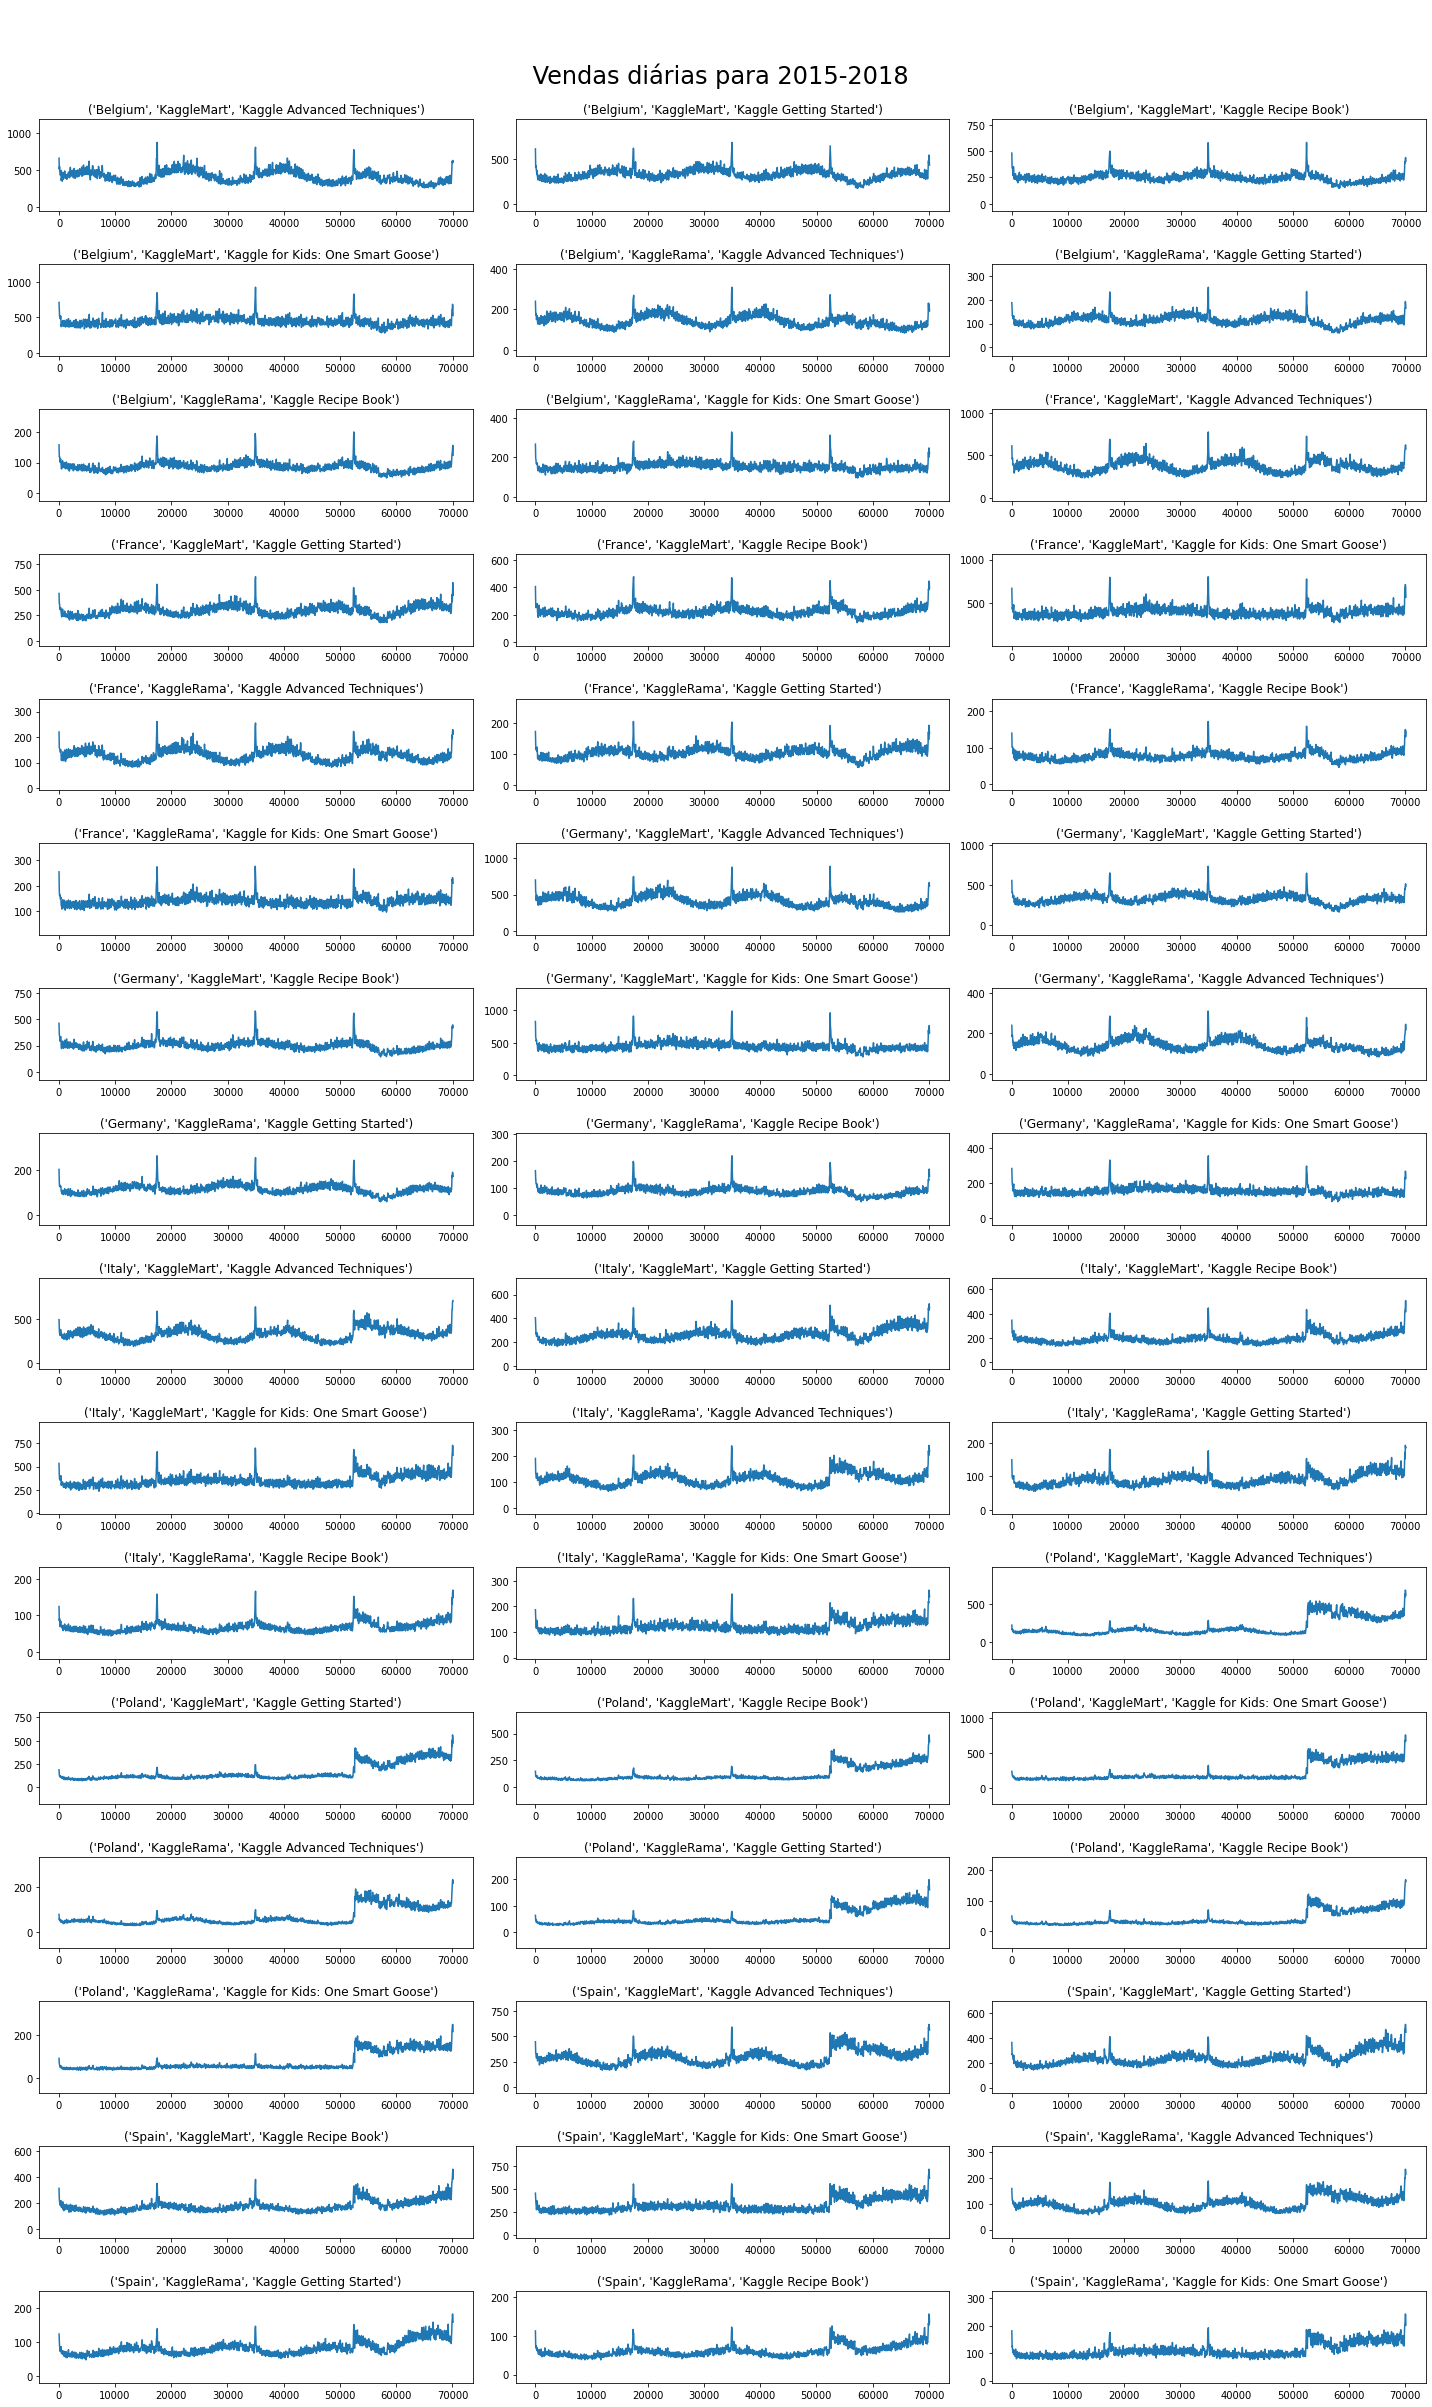

In [142]:
plt.figure(figsize=(20, 40))
for i, (combi, df) in enumerate(df1_train.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(20, 3, i+1, ymargin=.5)    
    ax.plot(df.num_sold)
    ax.set_title(combi)
    plt.tight_layout(h_pad=2.0)

plt.suptitle('\n\n Vendas diárias para 2015-2018', y=1.03, fontsize=24);
#plt.tight_layout(h_pad=3.0)

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
Podemos observar nos gráficos acima dos valores diários das 18 séries temporais dos quatro anos, claramente um picos altos no final de cada ano, se olharmos os gráficos de perto, veremos leves formas de onda que podem ser o efeito sazonais.
  
<br>   
    

**Observações:**
- Temos que modelar efeitos sazonais que dependem do produto.
- Temos que modelar ondas com comprimento de onda de um ano, bem como picos curtos.

    
Vamos ampliar o pico de fim de ano. Traçamos apenas os 31 dias de dezembro, em média ao longo dos quatro anos. 
    

</div>


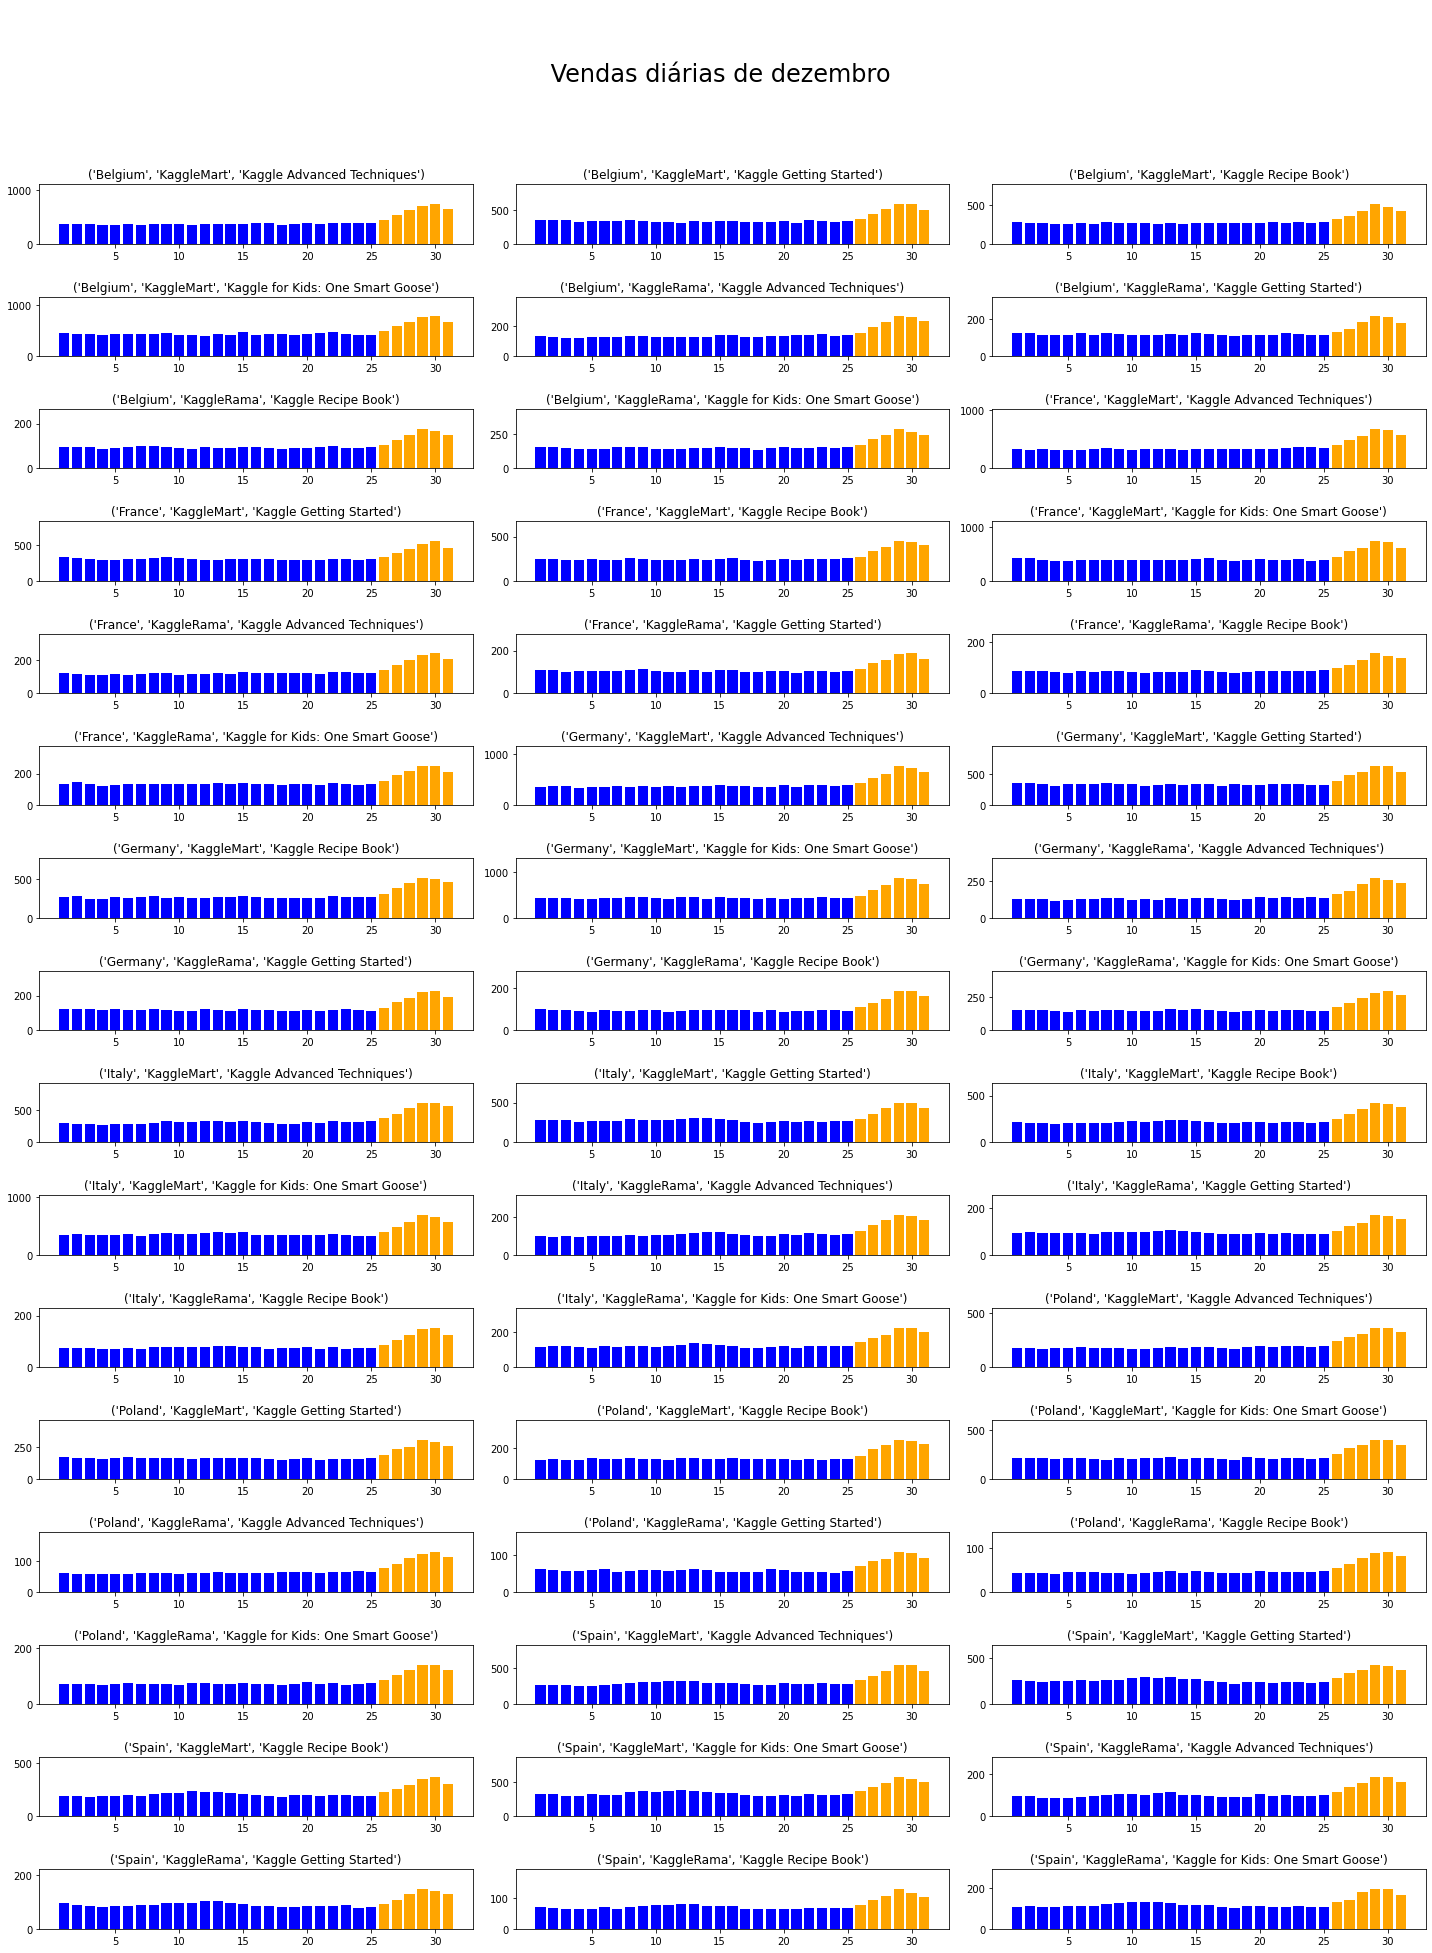

In [149]:
plt.figure(figsize=(20, 70))
for i, (combi, df) in enumerate(df1_train.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(45, 3, i+1, ymargin=0.5)
    ax.bar(range(1, 32),
           df.num_sold[df.date.dt.month==12].groupby(df.date.dt.day).mean(),
           color=['b'] * 25 + ['orange'] * 6)
    
    ax.set_title(combi)
    ax.set_xticks(ticks=range(5, 31, 5))
    
    plt.tight_layout(h_pad=2.0)
    
plt.suptitle('\n\n Vendas diárias de dezembro', y=1.03, fontsize=24);
#plt.tight_layout(h_pad=3.0)

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Os gráficos mostram que as vendas começam a crescer depois do Natal e atingem o pico no dia 30 de dezembro, temos que modelar a ocorrência desse pico, com a criação de novas variáveis. 
   

</div>

### 2.9.2. Vendas mensais e variação sazonal

ValueError: num must be 1 <= num <= 18, not 19

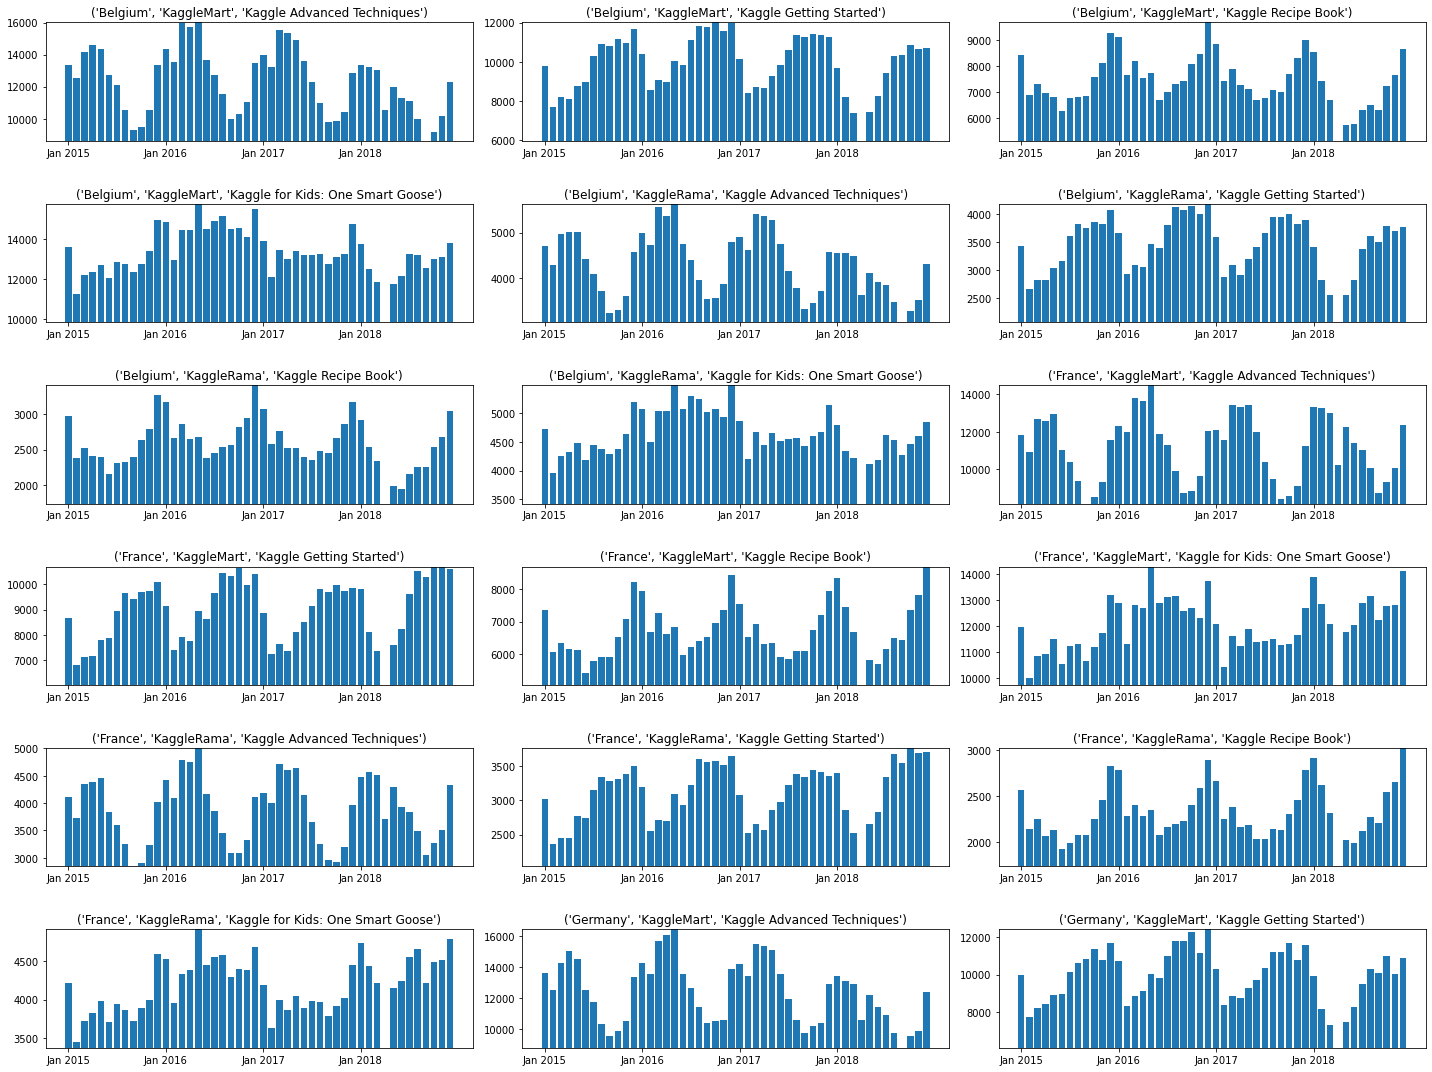

In [78]:
plt.figure(figsize=(20, 15))
for i, (combi, df) in enumerate(df1_train.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)    
    resampled = df.set_index('date').resample('M').num_sold.sum()
    ax.bar(range(len(resampled)), resampled)
    ax.set_title(combi)
    ax.set_ylim(resampled.min(), resampled.max())   
    ax.set_xticks(range(0, 48, 12)) 
    ax.set_xticklabels([f"Jan {y}" for y in range(2015, 2019)])
    plt.tight_layout(h_pad=3.0);
    
plt.suptitle('Vendas mensais para 2015-2018', y=1.03, fontsize=24);
plt.tight_layout(h_pad=3.0);

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
Nos gráficos mensais acima, mostra a variação sazonal e uma tendência crescente. O crescimento parece mais pronunciada para os **Kaggle stickers** do que para **Kaggle hats**. 
   
 <br>   
    
**Observação:**
- Devemos garantir que nossos modelos possam extrapolar o crescimento para o quinto ano, podemos ver a variação sazonal mais claramente se fizermos a média dos quatro anos e mostrarmos apenas 12 barras para os 12 meses:
    
</div>


ValueError: num must be 1 <= num <= 18, not 19

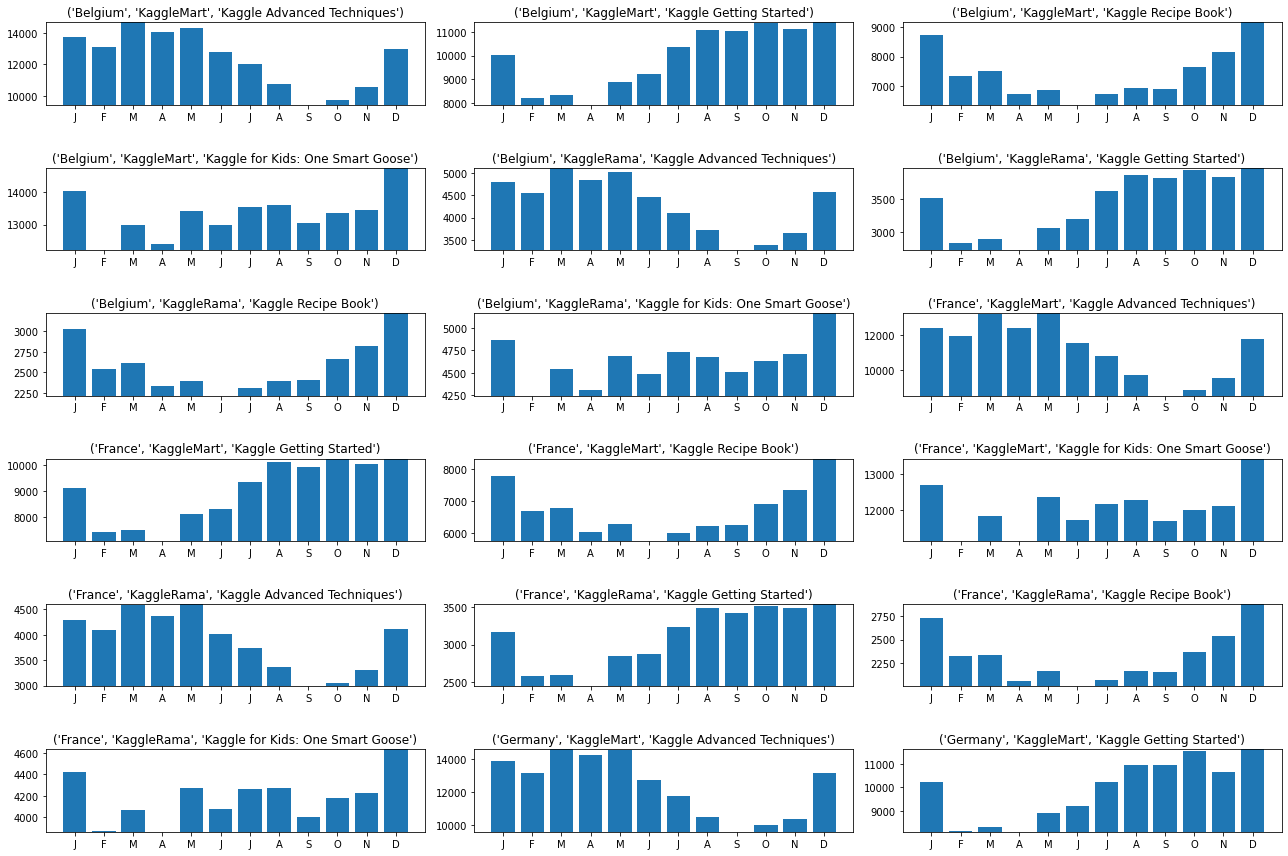

In [80]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(df1_train.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    resampled = df.set_index('date').resample('MS').sum()
    resampled = resampled.groupby(resampled.index.month).mean()
    ax.bar(range(1, 13), resampled.num_sold)   
    ax.set_title(combi)
    ax.set_ylim(resampled.num_sold.min(), resampled.num_sold.max())    
    ax.set_xticks(ticks=range(1, 13)) 
    ax.set_xticklabels('JFMAMJJASOND')
    plt.tight_layout(h_pad=3.0);
    
plt.suptitle('\n\n Vendas mensais para 2015-2018', y=1.03, fontsize=24);
plt.tight_layout(h_pad=3.0)
plt.show()

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
- O produto **Kaggle Hat** têm o máximo em abril ou maio e o mínimo em setembro, tem outro máximo (local) em dezembro e janeiro.

- O produto **Kaggle Mug** têm o máximo em dezembro e janeiro e o mínimo em junho ou julho, têm um pequeno máximo local em março. 

- O produto **Kaggle sticker** têm o máximo em dezembro e janeiro, com mínimo em fevereiro e segundo máximo em maio.

<br> 
    
**Observações:**
- Os três produto tem sazonalidades diferentes em cada mês, sendo assim, devemos nos preocupar em modelar esse fenômino para os produtos.  
    
</div>

### 2.9.3. Crescimento

ValueError: num must be 1 <= num <= 18, not 19

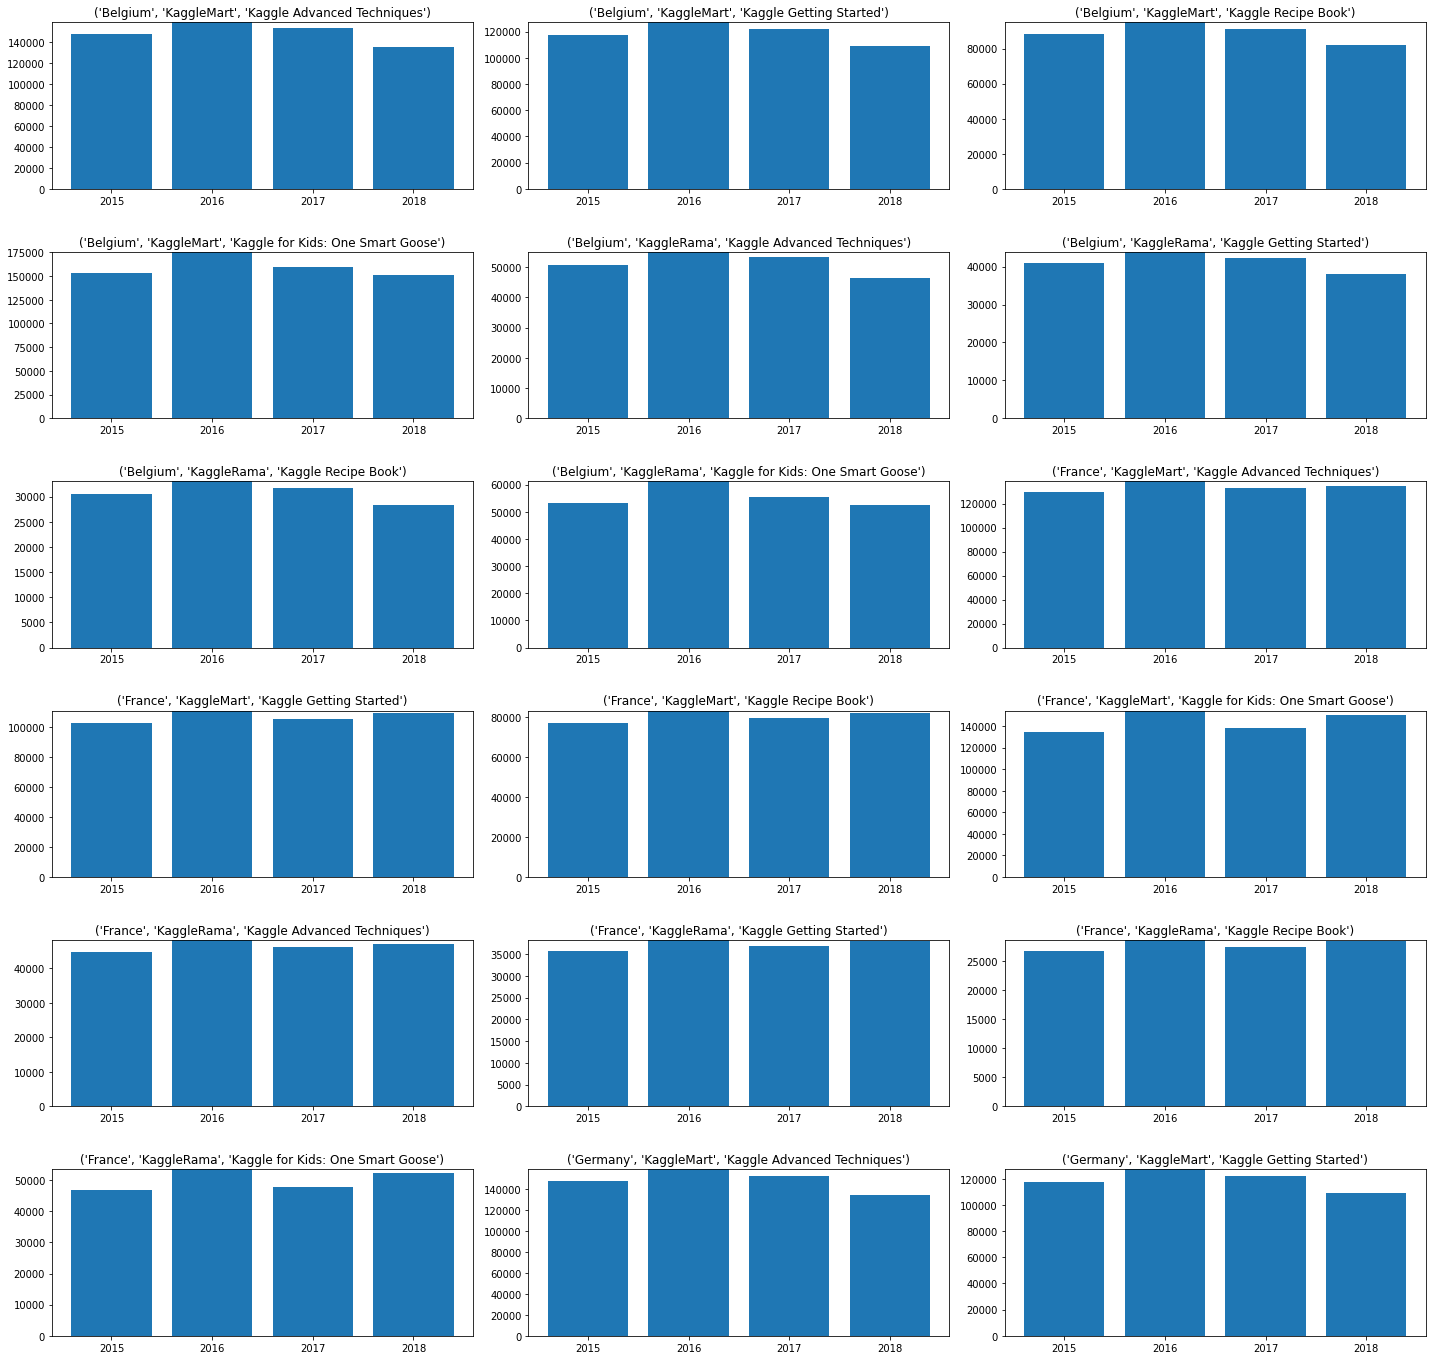

In [82]:
plt.figure(figsize=(20, 19))
for i, (combi, df) in enumerate(df1_train.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    resampled = df.set_index('date').resample('Y').sum()
    ax.bar(range(2015, 2019), resampled.num_sold, ) # color=icecream[4]
    ax.set_title(combi)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
    ax.set_ylim(0, resampled.num_sold.max())
    plt.tight_layout(h_pad=3.0);
            
plt.suptitle('\n\n Crescimento das vendas anuais para 2015-2018', y=1.03, fontsize=24);
plt.tight_layout(h_pad=3.0);

del resampled

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
A agregação das vendas por ano mostra a tendência de crescimento. Todas as combinações país-loja-produto mostram crescimento, mas há diferenças sutis:
- Na Noruega, 2016 foi um ano ruim com vendas inferiores a 2015.
- A Suécia não teve crescimento de 2017 a 2018.
- Em quase todos os lugares, a correria de fim de ano cresceu mais que o resto do ano.

**Observações**
- Temos que modelar uma taxa de crescimento que depende do país.
- O crescimento não é linear nem exponencial.
- Temos que modelar uma taxa de crescimento diferente em cada ano para as final e talvez outros efeitos sazonais.

Para uma análise mais ampla do tópico, consulte [esta discussão](https://www.kaggle.com/c/tabular-playground-series-jan-2022/discussion/298318). O resultado foi que os números de vendas do Kaggle dependem do PIB do país.

</div>

### 2.9.4. Dias úteis

ValueError: num must be 1 <= num <= 18, not 19

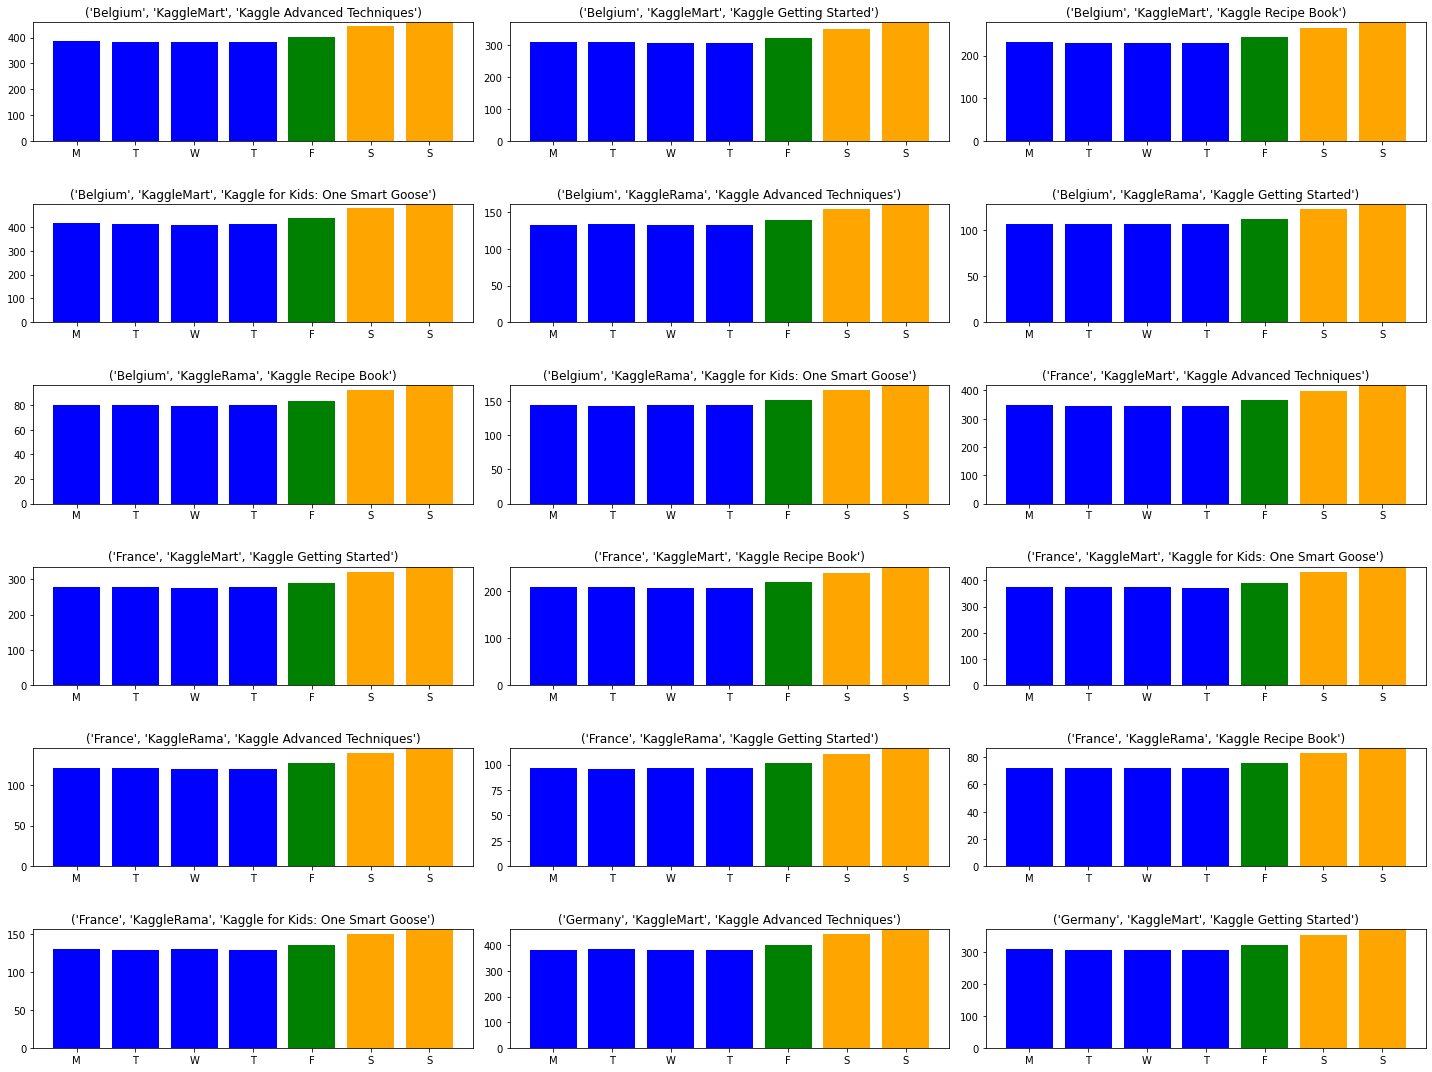

In [84]:
plt.figure(figsize=(20, 15))

for i, (combi, df) in enumerate(df1_train.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    resampled = df.groupby(df.date.dt.dayofweek).mean()
    ax.bar(range(7), 
           resampled.num_sold,
           color=['b']*4 + ['g'] + ['orange']*2)
    
    ax.set_title(combi)   
    ax.set_ylim(0, resampled.num_sold.max())    
    ax.set_xticks(ticks=range(7)) 
    ax.set_xticklabels(['M', 'T', 'W', 'T', 'F', 'S', 'S'])
    plt.tight_layout(h_pad=3.0);
    
plt.suptitle('\n\n Vendas por dia da semana',  y=1.03, fontsize=24);
plt.tight_layout(h_pad=3.0);

del resampled

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Sábados e domingos são os melhores dias (maiores vendas) para todos os produtos. Sexta-feira parece ser melhor do que de segunda a quinta-feira.

<br>        
    
**Observações:**
- Nosso modelo precisa distinguir pelo menos três fases da semana: Seg-Qui, Sex, Sáb-Dom.
    
</div>

## 2.9.5. Páscoa


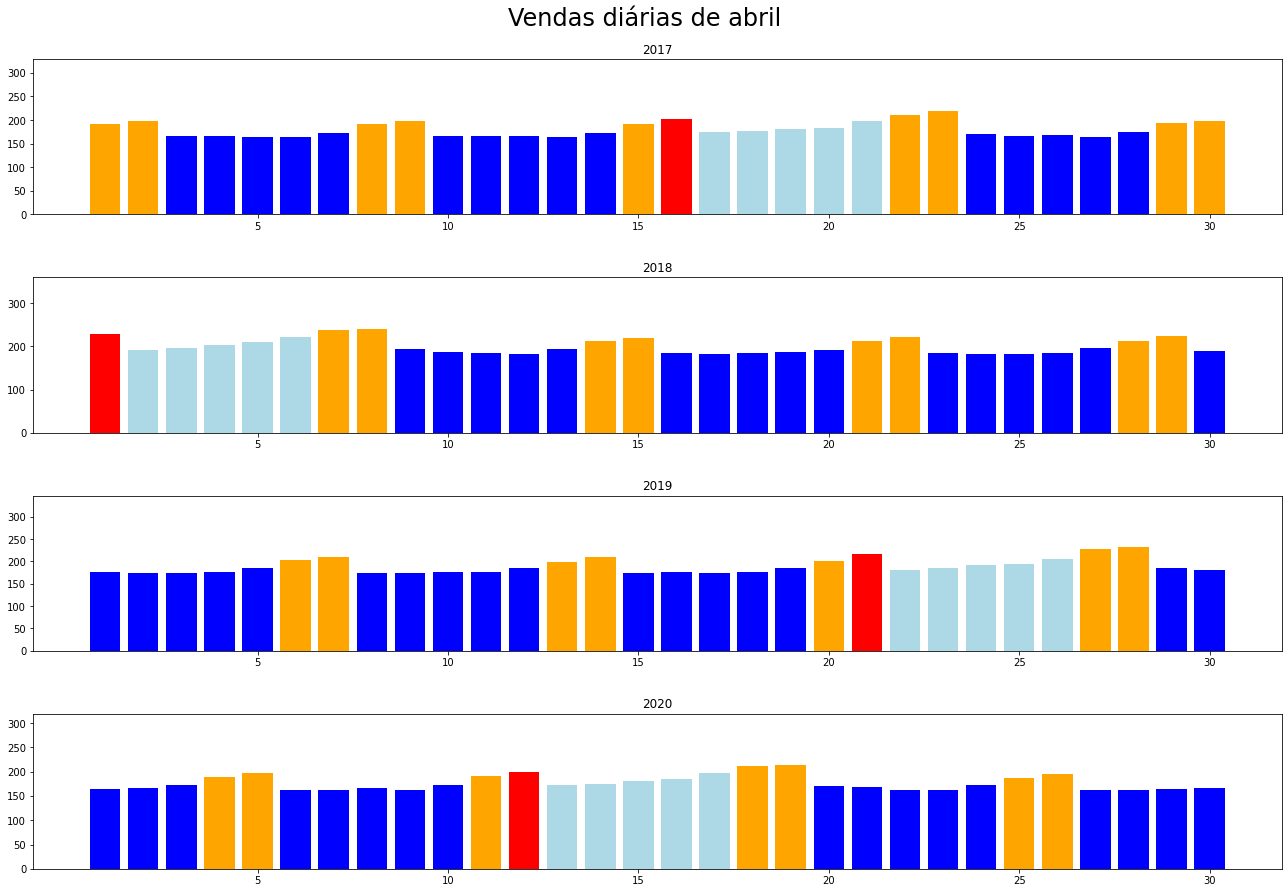

In [85]:
plt.figure(figsize=(18, 12))
for i, (year, df) in enumerate(df1_train.groupby(df1_train.date.dt.year)):
    
    df          = df.reset_index(drop=True)
    ax          = plt.subplot(4, 1, i+1, ymargin=0.5)
    april       = df.num_sold[(df.date.dt.month==4)].groupby(df.date.dt.day).mean()
    date_range  = pd.date_range(start=f'{year}-04-01', end=f'{year}-04-30', freq='D')
    easter_date = easter.easter(year)
    
    color = ['r' if d == easter_date else 'lightblue' \
             if (d.date()-easter_date).days in range(6) else 'b' \
             if d.dayofweek<5 else 'orange' for d in date_range]
    
    ax.bar(range(1, 31),
           april,
           color=color)
    
    ax.set_title(str(year))
    ax.set_xticks(ticks=range(5, 31, 5))
    
plt.tight_layout(h_pad=3.0)
plt.suptitle('Vendas diárias de abril', y=1.03, fontsize=24);

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
Nos gráricos acima mostramos as vendas diárias de abril dos quantro anos, os fins de semana são de cor laranja, o domingo de Páscoa é marcado em vermelho, a semana após a Páscoa é de cor azul clara, observamos que após a semana de  Páscoa, as vendas são maiores que o normal.    
       
<br>   
A Páscoa de 2016 foi no dia 27 de março,  o gráfico mostra apenas os últimos dias da semana após a Páscoa.

<br>
    
**Observação:**
- O modelo deve saber a data da Páscoa e contabilizar maior demanda na semana após a Páscoa.

</div>

# <div class="alert alert-success"> 3. Modelagem (baseline) </div> 

Como baseline vamos fazer um modelo com poucas variáveis transformadas em relação ao tempo, no próximo notebook(Feature engineering) vamos criar novas variáveis, com base nos insights desta EDA, abaixo foi criado um um função para gerar as nova variáveis.

## 3.1. Engenharia de recursos simples (sem feriados)

Neste modelo simples (baseline), consideramos o seguinte:
- país, loja, produto
- dias úteis
- variações sazonais por produto como uma série de Fourier com comprimentos de onda de 1 ano até 18 dias
- PIB do país

Os resíduos desse modelo simples nos permitirão entender o efeito dos feriados.

In [98]:
def create_features(df):
      
    def gpd(df_):
    
        df_['year'] = df_['date'].dt.year
        df_temp = pd.DataFrame()
        df_gdp  = pd.read_csv(path + 'Data/GDP_data_2015_to_2019_Finland_Norway_Sweden.csv')

        for col in df_gdp.columns[1:]: 
            df = df_gdp[['year',col]]
            df.columns = ['year', 'gpd']
            df['country'] = str.replace(col, 'GDP_','')
            df_temp = pd.concat([df_temp, df], axis=0)

        df_        = pd.merge(df_, df_temp, on=['country', 'year'], how='left') 
        df_.drop('year', axis=1, inplace=True)
        df_.head()    

        return df_

    def dammy(df_):    
        
        for col in df_.select_dtypes(object).columns[:]:        
            for col_ in df_[col].unique()[:-1]:
                df_[col_] = (df_[col]==col_).astype(int)  
            df_.drop(col, axis=1, inplace=True)
            
        return df_
       
    def fourier_series(df_):
        # Variações sazonais (série Fourier)
        # Os três produtos têm padrões sazonais diferentes
        dayofyear = df_.date.dt.dayofyear       
        for k in range(1, 3):
            df_[f'sin{k}']     = np.sin(dayofyear / 365 * 2 * np.math.pi * k)
            df_[f'cos{k}']     = np.cos(dayofyear / 365 * 2 * np.math.pi * k)
            #df_[f'mug_sin{k}'] = df_[f'sin{k}'] * df_['Kaggle Mug']
            #df_[f'mug_cos{k}'] = df_[f'cos{k}'] * df_['Kaggle Mug']
            #df_[f'hat_sin{k}'] = df_[f'sin{k}'] * df_['Kaggle Hat']
            #df_[f'hat_cos{k}'] = df_[f'cos{k}'] * df_['Kaggle Hat']
        
        return df_

    def label_encoder(df_, col_): 
        le = LabelEncoder()   
        for col in col_:
            df_[col] = le.fit_transform(df_[col])        
        return df_, 
        
    #df = gpd(df.copy())
    df = dammy(df.copy())
    df = fourier_series(df.copy())
    
    df['day_of_week']   = df['date'].dt.dayofweek.astype(int)
    df['quarter']       = df['date'].dt.quarter.astype(int)
    df['month']         = df['date'].dt.month.astype(int)
    df['year']          = df['date'].dt.year.astype(int)
    df['day_of_year']   = df['date'].dt.dayofyear.astype(int)
    df['day_of_month']  = df['date'].dt.day.astype(int)
    df['week_of_year']  = df['date'].dt.isocalendar().week.astype(int)
    df['week_of_month'] = df['week_of_year'].values // 4.35
        
    # Marca o dia da semana                                                                        
    df['is_thu']         =  (df['date'].dt.weekday == 4).astype(np.int)  # Friday
    df['is_fri_sat']     =  (df['date'].dt.weekday >= 5).astype(int)     # Saturday and Sunday
    
    df.drop('date', axis=1 , inplace=True)
    
    df = reduce_memory_usage(df, verbose=False)
    
    return df

In [99]:
df2_train = create_features(df1_train.copy())
df2_test  = create_features(df1_test.copy())
df2_train.shape , df2_test.shape

((70128, 24), (17520, 23))

In [100]:
df2_train.head()

,num_sold,Belgium,France,Germany,Italy,Poland,KaggleMart,Kaggle Advanced Techniques,Kaggle Getting Started,Kaggle Recipe Book,sin1,cos1,sin2,cos2,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,week_of_month,is_thu,is_fri_sat
0,663,1,0,0,0,0,1,1,0,0,0.017212,1.0,0.034424,0.999512,6,1,1,2017,1,1,52,11.0,0,1
1,615,1,0,0,0,0,1,0,1,0,0.017212,1.0,0.034424,0.999512,6,1,1,2017,1,1,52,11.0,0,1
2,480,1,0,0,0,0,1,0,0,1,0.017212,1.0,0.034424,0.999512,6,1,1,2017,1,1,52,11.0,0,1
3,710,1,0,0,0,0,1,0,0,0,0.017212,1.0,0.034424,0.999512,6,1,1,2017,1,1,52,11.0,0,1
4,240,1,0,0,0,0,0,1,0,0,0.017212,1.0,0.034424,0.999512,6,1,1,2017,1,1,52,11.0,0,1


## 3.2. Treinar o modelo

Vamos treinar o modelo nos dados de treinamento completo, a validação crzuzada virá mais tarde, neste momento vamos definir uma baseline. 


In [101]:
sc = StandardScaler() 

X_train = df2_train.drop(target, axis=1) 
y_train = df2_train[target]

X_train_sc  = sc.fit_transform(X_train)
y_train_log = np.log(y_train) 

model = Ridge()
model.fit(X_train_sc, y_train_log)
y_pred = np.exp(model.predict(X_train_sc)) 

calc_erro(y_train, y_pred)

RMSE : 48.73555
MAE  : 31.17226
MAPE : 0.16635
SMAPE: 16.62057


## 3.3. Gerar Submission 

In [104]:
X_test_sc   = sc.fit_transform(df2_test)
df_submission[target] = np.exp(model.predict(X_test_sc)).reshape(-1, 1)
df_submission.to_csv('Data/submission/sub_baseline_01.csv', index=False)

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Na primeira submissão obtivemos um smape de 7.26340. 
    
</div>

## 3.4. Seleção do Scaler

In [106]:
%%time

X_train = df2_train.drop(target, axis=1) 
y_train = df2_train[target]
X_test  = df2_test

scalers =[None, 
          MaxAbsScaler(),          
          MinMaxScaler(), 
          StandardScaler(),          
          RobustScaler(), 
          QuantileTransformer(output_distribution='normal', random_state=0)] 

smape_best  = 100 
scaler_best = ''

for i, sc in enumerate(scalers):
    
    print(sc)
        
    if sc==None:       
        X_train_sc  = X_train     
        X_test_sc   = X_test
        y_train_sc = np.log(y_train)
    else:        
        X_train_sc  = sc.fit_transform(X_train)   
        X_test_sc   = sc.transform(X_test)
        y_train_sc = np.log(y_train.values)
          
    model = Ridge()
    model.fit(X_train_sc, y_train_log) 
        
    if sc==None:        
        y_pred      = np.exp(model.predict(X_train_sc))
        y_pred_test = np.exp(model.predict(X_test_sc))
    else: 
        y_pred      = np.exp(model.predict(X_train_sc))#.reshape(-1, 1)
        y_pred_test = np.exp(model.predict(X_test_sc))
    
    erro = calc_erro(y_train_sc, y_pred, False, True)
    print(erro , end='\n\n')
    
            
    if smape_best > erro: 
        smape_best  = erro
        scaler_best = sc
        
    
    # Gera arquivo de submissão
    file_name   = 'sub_' + str(i) + '_scaler_' + str(sc)[0:4].lower() + '.csv'       
    df_submission[target] = y_pred_test.reshape(-1, 1)
    df_submission.to_csv('Data//submission/' + file_name, index=False)

                
print('SMAPE  : {:2.5f}'.format(smape_best))
print('Scaler : {}'.format(scaler_best))
print()

None
185.90387

MaxAbsScaler()
185.9241

MinMaxScaler()
185.9041

StandardScaler()
185.90404

RobustScaler()
185.90416

QuantileTransformer(output_distribution='normal', random_state=0)
185.89667

SMAPE  : 100.00000
Scaler : 

CPU times: total: 562 ms
Wall time: 646 ms


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Submissões:    
 
- None: 9.44677
- `MaxAbsScaler: 6.71064`
- MinMaxScaler:  9.14974
- StandardScaler:  8.97770
- RobustScaler: 9.13283
- QuantileTransformer: 22.24053


Vamos fazer uma simples validação cruzada, vamos treinar com 3 anos e fazer a validação no quarto ano. 
</div>

## 3.5. Validação cruzada

In [116]:
%%time 
X_train = df2_train.drop(target, axis=1) 
y_train = df2_train[target]

oof        = pd.Series(0.0, index=X_train.index)
score_list = []

kf    = GroupKFold(n_splits=4)
kf    = ts_cv = TimeSeriesSplit(n_splits=4) 
sc_mm = MinMaxScaler()
sc_st = StandardScaler()

for fold, (idx_train, idx_valid) in enumerate(kf.split(X_train, groups=X_train.year)): 
    
    X_tr, X_vl = X_train.iloc[idx_train], X_train.iloc[idx_valid]    
    y_tr, y_vl = y_train.iloc[idx_train], y_train.iloc[idx_valid]
   
    y_tr_log = np.log(y_tr)
    y_vl_log = np.log(y_vl)
    
    X_tr = sc_st.fit_transform(sc.fit_transform(X_tr))
    X_vl = sc_st.transform(sc.transform(X_vl))
    
    model = Ridge()
    
    model.fit(X_tr, y_tr_log)
    y_pred_valid = np.exp(model.predict(X_vl))
      
    oof.update(pd.Series(y_pred_valid.ravel(), index=idx_valid))
    
    score = calc_erro(y_vl, y_pred_valid, False, True)
    score_list.append(score)
    
    print('Fold {} - SMAPE: {:2.5f}'.format(fold +1, score)) 

print('Fold mean: {:2.5f}'.format(np.mean(score_list)))
print()   

Fold 1 - SMAPE: 14.14006
Fold 2 - SMAPE: 26.12319
Fold 3 - SMAPE: 17.18759
Fold 4 - SMAPE: 29.11793
Fold mean: 21.64219

CPU times: total: 578 ms
Wall time: 588 ms


In [108]:
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

Fold: 0
TRAIN indices: [    0     1     2 ... 11685 11686 11687] 
 TEST indices: [11688 11689 11690 ... 23373 23374 23375]


Fold: 1
TRAIN indices: [    0     1     2 ... 23373 23374 23375] 
 TEST indices: [23376 23377 23378 ... 35061 35062 35063]


Fold: 2
TRAIN indices: [    0     1     2 ... 35061 35062 35063] 
 TEST indices: [35064 35065 35066 ... 46749 46750 46751]


Fold: 3
TRAIN indices: [    0     1     2 ... 46749 46750 46751] 
 TEST indices: [46752 46753 46754 ... 58437 58438 58439]


Fold: 4
TRAIN indices: [    0     1     2 ... 58437 58438 58439] 
 TEST indices: [58440 58441 58442 ... 70125 70126 70127]




NameError: name 'cmap_cv' is not defined

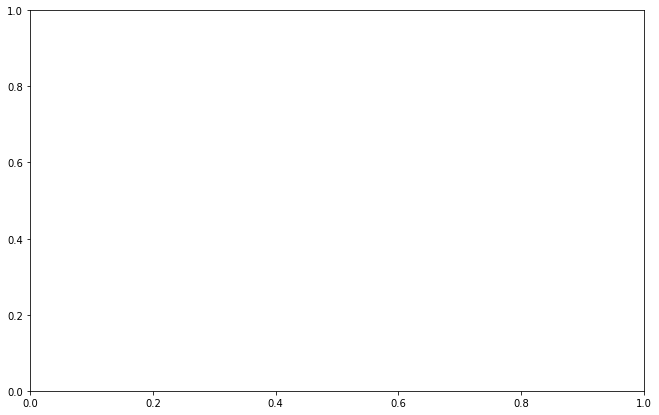

In [110]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)

for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print("Fold: {}".format(fold))
    print("TRAIN indices:", train_index, "\n", "TEST indices:", test_index)
    print("\n")
    #X_train, X_test = X_train.iloc[train_index], X_train.iloc[test_index]
    #y_train, y_test = y[train_index], y[test_index]
    
plot_cv_indices(tscv,n_splits, X_train, y_train)

In [112]:
X_train[train_index]

KeyError: "None of [Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,\n                9,\n            ...\n            58430, 58431, 58432, 58433, 58434, 58435, 58436, 58437, 58438,\n            58439],\n           dtype='int64', length=58440)] are in the [columns]"

In [113]:
Fold 1 - SMAPE: 8.56014
Fold 2 - SMAPE: 8.42120
Fold 3 - SMAPE: 7.22264
Fold 4 - SMAPE: 7.90401
Fold mean: 8.02700

SyntaxError: invalid syntax (1379074248.py, line 1)

In [115]:
X_test_sc   = sc.transform(X_test)
y_pred_test = np.exp(model.predict(X_test_sc))

# Gera arquivo de submissão
file_name   = 'sub_cv_bsl_' + '_scaler_' + str(sc)[0:4].lower() + '.csv'       
df_submission[target] = y_pred_test.reshape(-1, 1)
df_submission.to_csv('Data//submission/' + file_name, index=False)
# 7.07340
# 7.59399

In [ ]:
Fold: 1
SMAPE: 8.71080

Fold: 2
SMAPE: 8.34530

Fold: 3
SMAPE: 7.21569

Fold: 4
SMAPE: 7.94003

Wall time: 102 ms

In [997]:
#%%time
RUNS = 1 # should be 1. increase the number of runs only if you want see how the result depends on the random seed
OUTLIERS = True
TRAIN_VAL_CUT = datetime(2018, 1, 1)
LOSS_CORRECTION = 1

# Make the results reproducible
np.random.seed(202100)

total_start_time = datetime.now()
oof = pd.Series(0.0, index=train_df.index)
score_list = []
for run in range(RUNS):
    kf = GroupKFold(n_splits=4)
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, groups=train_df.date.dt.year)):
        X_tr = train_df.iloc[train_idx]
        X_va = train_df.iloc[val_idx]
        #print(f"Fold {run}.{fold}")
        preproc, model = fit_model(X_tr, X_va)

print()
print(f"Average SMAPE: {sum(score_list) / len(score_list):.5f}")
with open('oof.pickle', 'wb') as handle: pickle.dump(oof, handle)

NameError: name 'train_df' is not defined

In [ ]:
def fit_model(X_tr, X_va=None, outliers=False):
    
    """Scale the data, fit a model, plot the training history and validate the model"""
    start_time = datetime.now()

    # Preprocess the data
    X_tr_f  = X_tr[features]
    preproc = StandardScaler()
    X_tr_f  = preproc.fit_transform(X_tr_f)
    y_tr    = X_tr.num_sold.values.reshape(-1, 1)
    
    # Train the model
    #model = LinearRegression()
    #model = HuberRegressor(epsilon=1.20, max_iter=500)
    model = Ridge()
    model.fit(X_tr_f, np.log(y_tr).ravel())

    if X_va is not None:
        # Preprocess the validation data
        X_va_f = X_va[features]
        X_va_f = preproc.transform(X_va_f)
        y_va = X_va.num_sold.values.reshape(-1, 1)

        # Inference for validation
        y_va_pred = np.exp(model.predict(X_va_f)).reshape(-1, 1)
        oof.update(pd.Series(y_va_pred.ravel(), index=X_va.index))
        
        # Evaluation: Execution time and SMAPE
        smape_before_correction = np.mean(smape_loss(y_va, y_va_pred))
        #y_va_pred *= LOSS_CORRECTION
        smape = np.mean(smape_loss(y_va, y_va_pred))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f}   (before correction: {smape_before_correction:.5f})")
        score_list.append(smape)
        
        # Plot y_true vs. y_pred
        if fold == 0:
            plt.figure(figsize=(10, 10))
            plt.scatter(y_va, y_va_pred, s=1, color='r')
            #plt.scatter(np.log(y_va), np.log(y_va_pred), s=1, color='g')
            plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
            plt.gca().set_aspect('equal')
            plt.xlabel('y_true')
            plt.ylabel('y_pred')
            plt.title('OOF Predictions')
            plt.show()
        
    return preproc, model

In [558]:
X_train_[X_train_['year']<2015].shape

(0, 33)

In [563]:
#def cross_valid(model, X_train_, y_train_, feature_=None): 


X_train_ =  df2_train.drop('num_sold', axis=1).copy()
y_train_ = df2_train['num_sold'].copy()

for fold, year in enumerate(X_train_['year'].unique()):
    print('Fold: {}'.format(fold+1))
    
    X_tr = X_train_[X_train_['year']<=year]
    X_vl = X_train_[X_train_['year']>year]
    
    y_tr = 
    print(X_tr.shape, X_vl.shape)
    print()


Fold: 1
(6570, 33) (19728, 33)

Fold: 2
(13158, 33) (13140, 33)

Fold: 3
(19728, 33) (6570, 33)

Fold: 4
(26298, 33) (0, 33)



In [620]:
X_train_ = df2_train.drop(target, axis=1).copy()
y_train_ = df2_train[target].astype(int)
feature_ = None

if feature_!=None:
    X_train_ = X_train_[feature_]
        
kf_ts = TimeSeriesSplit(n_splits       = 4,
                        #gap            = 12,
                        #max_train_size = 10000,
                       # test_size      = 1461
                       )

for fold, (idx_tr, idx_vl) in enumerate(kf_ts.split(X_train_)):
    
    X_tr, X_vl = X_train_.iloc[idx_tr], X_train_.iloc[idx_vl]  
    y_tr, y_vl = y_train_.iloc[idx_tr], y_train_.iloc[idx_vl]  
    
    sc_tr = StandardScaler()
    sc_vl = StandardScaler()
    
    #X_tr = sc_tr.fit_transform(X_tr)
    #X_vl = sc_tr.transform(X_vl)
    
    y_tr = np.log(y_tr)
    y_vl = np.log(y_vl)
    
    model.fit(X_tr,  y_tr) 
      
    y_pred = np.exp(model.predict(X_vl))#.reshape(1, -1)
    
    erro = calc_erro(y_vl, y_pred, False, True)
    

SMAPE: 191.42359
SMAPE: 191.52756
SMAPE: 191.90431
SMAPE: 192.17726


In [495]:
SMAPE: 8.94295
SMAPE: 7.44540
SMAPE: 7.67690
SMAPE: 6.88091

In [496]:
X_train_

,gpd,Finland,Norway,KaggleMart,Kaggle Mug,Kaggle Hat,sin1,cos1,mug_sin1,mug_cos1,hat_sin1,hat_cos1,sin2,cos2,mug_sin2,mug_cos2,hat_sin2,hat_cos2,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,week_of_month,is_thu,is_fri_sat,is_wknd,is_month_start,is_month_end,week_block_num,quarter_block_num
0,234.5,1,0,1,1,0,0.017212,1.0,0.017212,1.0,0.000000,0.0,0.034424,0.999512,0.034424,0.999512,0.000000,0.000000,3,1,1,2015,1,1,1,0.0,0,0,0,1,0,1,1
1,234.5,1,0,1,0,1,0.017212,1.0,0.000000,0.0,0.017212,1.0,0.034424,0.999512,0.000000,0.000000,0.034424,0.999512,3,1,1,2015,1,1,1,0.0,0,0,0,1,0,1,1
2,234.5,1,0,1,0,0,0.017212,1.0,0.000000,0.0,0.000000,0.0,0.034424,0.999512,0.000000,0.000000,0.000000,0.000000,3,1,1,2015,1,1,1,0.0,0,0,0,1,0,1,1
3,234.5,1,0,0,1,0,0.017212,1.0,0.017212,1.0,0.000000,0.0,0.034424,0.999512,0.034424,0.999512,0.000000,0.000000,3,1,1,2015,1,1,1,0.0,0,0,0,1,0,1,1
4,234.5,1,0,0,0,1,0.017212,1.0,0.000000,0.0,0.017212,1.0,0.034424,0.999512,0.000000,0.000000,0.034424,0.999512,3,1,1,2015,1,1,1,0.0,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26293,555.5,0,0,1,0,1,-0.000000,1.0,-0.000000,0.0,-0.000000,1.0,-0.000000,1.000000,-0.000000,0.000000,-0.000000,1.000000,0,4,12,2018,365,31,1,0.0,0,0,0,0,1,209,16
26294,555.5,0,0,1,0,0,-0.000000,1.0,-0.000000,0.0,-0.000000,0.0,-0.000000,1.000000,-0.000000,0.000000,-0.000000,0.000000,0,4,12,2018,365,31,1,0.0,0,0,0,0,1,209,16
26295,555.5,0,0,0,1,0,-0.000000,1.0,-0.000000,1.0,-0.000000,0.0,-0.000000,1.000000,-0.000000,1.000000,-0.000000,0.000000,0,4,12,2018,365,31,1,0.0,0,0,0,0,1,209,16
26296,555.5,0,0,0,0,1,-0.000000,1.0,-0.000000,0.0,-0.000000,1.0,-0.000000,1.000000,-0.000000,0.000000,-0.000000,1.000000,0,4,12,2018,365,31,1,0.0,0,0,0,0,1,209,16


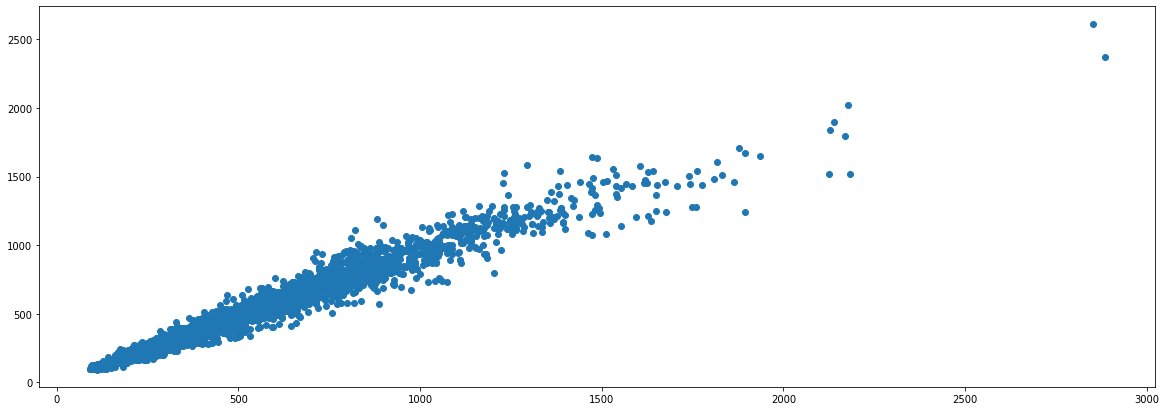

In [469]:
residuals = y_valid, y_pred
plt.figure(figsize = (20,7))
plt.scatter(y_valid, y_pred)
plt.title("")
plt.show()

In [ ]:
MaxAbsScaler()
SMAPE: 7.43165

StandardScaler()
SMAPE: 7.43059

MinMaxScaler()
SMAPE: 7.44385

RobustScaler()
SMAPE: 7.43635

QuantileTransformer(output_distribution='normal', random_state=0)
SMAPE: 7.45119

In [ ]:
def create_features(df, target):

    def gpd(df):
        df_temp = pd.DataFrame()
        for col in df_gdp.columns[1:]: 
            df_ = df_gdp[['year',col]]
            df_.columns = ['year', 'gpd']
            df_['country'] = str.replace(col, 'GDP_','')
            df_temp = pd.concat([df_temp, df_], axis=0)
          
        df        = pd.merge(df, df_temp, on=['country', 'year'], how='left') 
        df['gpd'] = np.log(df['gpd'])
        
        return df
    
    df['hour']          = df['date'].dt.hour.astype(int)
    df['day_of_week']   = df['date'].dt.dayofweek.astype(int)
    df['quarter']       = df['date'].dt.quarter.astype(int)
    df['month']         = df['date'].dt.month.astype(int)
    df['year']          = df['date'].dt.year.astype(int)
    df['day_of_year']   = df['date'].dt.dayofyear.astype(int)
    df['day_of_month']  = df['date'].dt.day.astype(int)
    df['week_of_year']  = df['date'].dt.isocalendar().week.astype(int)
    df['week_of_month'] = df['week_of_year'].values // 4.35
    df                  = gpd(df)
    
    # day labeling features                                                                       
    df['is_mon'] = np.where(df['day_of_week'] == 1, 1, 0)                                                                                            
    df['is_tue'] = np.where(df['day_of_week'] == 2, 1, 0)                                                                                         
    df['is_wed'] = np.where(df['day_of_week'] == 3, 1, 0)                                                                                         
    df['is_thu'] = np.where(df['day_of_week'] == 4, 1, 0)                                                                                         
    df['is_fri'] = np.where(df['day_of_week'] == 5, 1, 0)                                                                                         
    df['is_sat'] = np.where(df['day_of_week'] == 6, 1, 0)                                                                                         
    df['is_sun'] = np.where(df['day_of_week'] == 7, 1, 0)   
    
    df['is_wknd']        = df['date'].dt.weekday // 4
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end']   = df['date'].dt.is_month_end.astype(int)
    
    '''
    df['lag_6_hrs']   = df[target].shift(6)
    df['lag_12_hrs']  = df[target].shift(12)
    df['lag_24_hrs']  = df[target].shift(24)
    
    df['mean_6_hrs']  = df[target].rolling(window = 6).mean()
    df['mean_12_hrs'] = df[target].rolling(window = 12).mean()
    df['mean_24_hrs'] = df[target].rolling(window = 24).mean()
    df['std_6_hrs']   = df[target].rolling(window = 6).std()
    df['std_12_hrs']  = df[target].rolling(window = 12).std()
    df['std_24_hrs']  = df[target].rolling(window = 24).std()
    df['max_6_hrs']   = df[target].rolling(window = 6).max()
    df['max_12_hrs']  = df[target].rolling(window = 12).max()
    df['max_24_hrs']  = df[target].rolling(window = 24).max()
    df['min_6_hrs']   = df[target].rolling(window = 6).min()
    df['min_12_hrs']  = df[target].rolling(window = 12).min()
    df['min_24_hrs']  = df[target].rolling(window = 24).min()
    '''
    
    
    # generating some new features from aggregation of sales within different time frames
    # https://www.kaggle.com/hikmetsezen/base-model-with-lightgbm-on-demand-forecasting
    shift_values = [0, 0, 0, 0, 0, 0, 12, 12]
    feat_list    = ['day_of_week', 'week_of_month', 'week_of_year', 'month', 
                    'quarter', 'is_wknd', 'day_of_week', 'week_of_month']
    

    #for time_item, shift_val in zip(feat_list, shift_values):
        #print(shift_val)
        # 'country','store','product'
        
        #grouped_df = df.groupby(['store', 'item', time_item])['sales'].expanding().mean().shift(shift_val).bfill().reset_index()
        #grouped_df.columns = ['store', 'item', time_item, 'date', time_item + f'_ex_avg_sale{str(shift_val)}']
        #grouped_df = grouped_df.sort_values(by=['item', 'store', 'date'])
        #df[time_item + f'_ex_avg_sale{str(shift_val)}'] = grouped_df[time_item + f'_ex_avg_sale{str(shift_val)}'].values

    
    
    
    # Easter
    easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    df['days_from_easter'] = (df.date - easter_date).dt.days.clip(-3, 59)
    df.loc[df['days_from_easter'].isin(range(12, 39)), 'days_from_easter'] = 12 # reduce overfitting
   
    '''
    # Last Wednesday of June
    wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})

    df['days_from_wed_jun'] = (df.date - wed_june_date).dt.days.clip(-5, 5)
    
    
    # First Sunday of November (second Sunday is Father's Day)
    sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
     '''
    #df['days_from_sun_nov'] = (df.date - sun_nov_date).dt.days.clip(-1, 9)

    day  = 24*60*60
    year = (365.2425)*day

    timestamp_s    = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M:%S')
    timestamp_s    = timestamp_s.map(pd.Timestamp.timestamp)
    df['day_sin']  = np.sin(timestamp_s * (2 * np.pi / day))
    df['day_cos']  = np.cos(timestamp_s * (2 * np.pi / day))
    df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

    # Realizando os limitadores de marcação de outlier
    #superior      = df[target].quantile(0.95)
    #inferior      = df[target].quantile(0.05)
    #df['outlier'] = np.where(df[target]>superior,1,np.where(df[target]<inferior,-1,0))
    
    
    # season:
    # - Winter -> December (12), January (01) and February (02);
    # - Spring -> March (03), April (04) and May (05);
    # - Summer -> Jun (06), July (07) and August (08);
    # - Autumn -> September (09), October (10) and November (11).
    df['season'] = df['date'].apply(lambda x: 'winter' 
                                      if 
                                      x.month == 12 or x.month == 1 or 
                                      x.month == 2 else 'spring' 
                                      if  
                                      x.month == 3 or x.month == 4 or 
                                      x.month == 5 else 'summer' 
                                      if  
                                      x.month == 6 or x.month == 7 or 
                                      x.month == 8 else 'autumn' 
                                      if  
                                      x.month == 9 or x.month == 10 or 
                                      x.month == 11 else '')
    
    
    ## holiday:
    # I will use the "holidays" library to identify whether the date represents a holiday. An idea for a next cycle in the project is to differentiate, according to some rule, the different dates of the holidays.
    # The documentation of this librarie is in this link: https://pypi.org/project/holidays/
    # Another rule that I will use is to consider the eve of the dates as a "holiday".
    '''
    df['holidays'] = df['date'].apply(lambda x: 1 
                                      if x in holidays.US() else 1 
                                      if x + datetime.timedelta(days=1) 
                                      in holidays.US() else 0)

    '''
    col_dammy = ['season', 'country', 'store', 'product']
    
    df = pd.concat([df, pd.get_dummies(df[col_dammy],  prefix='', prefix_sep='')], axis=1) 
    
    df = df.dropna()
    #y = X[target]

    # Seasonal variations (Fourier series)
    # The three products have different seasonal patterns
    dayofyear = df.date.dt.dayofyear
    for k in range(1, 3):
        df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * np.math.pi * k)
        df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * np.math.pi * k)
        df[f'mug_sin{k}'] = df[f'sin{k}'] * df['Kaggle Mug']
        df[f'mug_cos{k}'] = df[f'cos{k}'] * df['Kaggle Mug']
        df[f'hat_sin{k}'] = df[f'sin{k}'] * df['Kaggle Hat']
        df[f'hat_cos{k}'] = df[f'cos{k}'] * df['Kaggle Hat']
        
    col_dammy.append('date')
    #col_dammy.append(target)
    df.drop(col_dammy, axis=1 , inplace=True)
    
    df = reduce_memory_usage(df)
    
    return df

# OLHAR
- https://www.kaggle.com/hiro5299834/tps-jan-2022-blend-stacking-models
- https://goldinlocks.github.io/Time-Series-Cross-Validation/
- https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model/notebook

- https://github.com/ledmaster/notebooks_tutoriais/blob/master/live12_timeseries_prophet/nb1.ipynb
- https://sigmoidal.ai/series-temporais-time-series-com-python/
- https://romanorac.github.io/2020/05/22/data-science-is-fun.html
- https://romanorac.github.io/

- https://www.kdnuggets.com/2020/04/lstm-time-series-prediction.html
- https://public.bitmex.com/?prefix=data/trade/
- http://localhost:8888/notebooks/Git/Seiries%20Temporais/LSTM/Untitled.ipynb
- https://analyticsindiamag.com/tutorial-on-univariate-single-step-style-lstm-in-time-series-forecasting/

- https://www.tensorflow.org/tutorials/structured_data/time_series
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
- https://towardsdatascience.com/lstm-framework-for-univariate-time-series-prediction-d9e7252699e
- 



# AULA
- https://proeducacional.com/ead/curso-cga-modulo-i/capitulos/capitulo-4/aulas/analise-de-series-temporais/
- https://medium.com/data-hackers/series-temporais-parte-1-a0e75a512e72


In [ ]:
def create_features(df, target):

    def gpd(df):
        df_temp = pd.DataFrame()
        for col in df_gdp.columns[1:]: 
            df_ = df_gdp[['year',col]]
            df_.columns = ['year', 'gpd']
            df_['country'] = str.replace(col, 'GDP_','')
            df_temp = pd.concat([df_temp, df_], axis=0)
          
        df        = pd.merge(df, df_temp, on=['country', 'year'], how='left') 
        df['gpd'] = np.log(df['gpd'])
        
        return df
    
    df['hour']          = df['date'].dt.hour.astype(int)
    df['day_of_week']   = df['date'].dt.dayofweek.astype(int)
    df['quarter']       = df['date'].dt.quarter.astype(int)
    df['month']         = df['date'].dt.month.astype(int)
    df['year']          = df['date'].dt.year.astype(int)
    df['day_of_year']   = df['date'].dt.dayofyear.astype(int)
    df['day_of_month']  = df['date'].dt.day.astype(int)
    df['week_of_year']  = df['date'].dt.isocalendar().week.astype(int)
    df['week_of_month'] = df['week_of_year'].values // 4.35
    df                  = gpd(df)
    
    col_dammy = ['country', 'store', 'product']
    
    df = pd.concat([df, pd.get_dummies(df[col_dammy],  prefix='', prefix_sep='')], axis=1) 
    
    df.drop(col_dammy, axis=1 , inplace=True)
    df.drop('date', axis=1 , inplace=True)
    
    return df

In [ ]:
# Feature engineering
def engineer(df):
    """Return a new dataframe with the engineered features"""
    
    def get_gdp(row):
        country = 'GDP_' + row.country
        return gdp_df.loc[row.date.year, country]
        
    new_df = pd.DataFrame({#'gdp': np.log(df.apply(get_gdp, axis=1)),
                           'wd4': df.date.dt.weekday == 4, # Friday
                           'wd56': df.date.dt.weekday >= 5, # Saturday and Sunday
                          })

    # One-hot encoding (no need to encode the last categories)
    for country in ['Finland', 'Norway']:
        new_df[country] = df.country == country
    new_df['KaggleRama'] = df.store == 'KaggleRama'
    for product in ['Kaggle Mug', 'Kaggle Hat']:
        new_df[product] = df['product'] == product
        
    # Seasonal variations (Fourier series)
    # The three products have different seasonal patterns
    dayofyear = df.date.dt.dayofyear
    for k in range(1, 3):
        new_df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * np.math.pi * k)
        new_df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * np.math.pi * k)
        new_df[f'mug_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Mug']
        new_df[f'mug_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Mug']
        new_df[f'hat_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Hat']
        new_df[f'hat_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Hat']

    return new_df

In [ ]:
# Feature engineering for holidays
def engineer_more(df):
    """Return a new dataframe with more engineered features"""
    new_df = engineer(df)

    # End of year
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d)
                                      for d in range(24, 32)}),
                        pd.DataFrame({f"n-dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in range(24, 32)}),
                        pd.DataFrame({f"f-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Finland')
                                      for d in range(1, 14)}),
                        pd.DataFrame({f"jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in range(1, 10)}),
                        pd.DataFrame({f"s-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Sweden')
                                      for d in range(1, 15)})],
                       axis=1)
    
    # May
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) 
                                      for d in list(range(1, 10))}), #  + list(range(17, 25))
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in list(range(19, 26))})],
                       axis=1)
    
    # June and July
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"june{d}":
                                      (df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Sweden')
                                      for d in list(range(8, 14))}),
                        #pd.DataFrame({f"june{d}":
                        #              (df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Norway')
                        #              for d in list(range(22, 31))}),
                        #pd.DataFrame({f"july{d}":
                        #              (df.date.dt.month == 7) & (df.date.dt.day == d) & (df.country == 'Norway')
                        #              for d in list(range(1, 3))})],
                       ],
                       axis=1)
    
    # Last Wednesday of June
    wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"wed_june{d}": 
                                      (df.date - wed_june_date == np.timedelta64(d, "D")) & (df.country != 'Norway')
                                      for d in list(range(-4, 6))})],
                       axis=1)
    
    # First Sunday of November
    sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"sun_nov{d}": 
                                      (df.date - sun_nov_date == np.timedelta64(d, "D")) & (df.country != 'Norway')
                                      for d in list(range(0, 9))})],
                       axis=1)
    
    # First half of December (Independence Day of Finland, 6th of December)
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Finland')
                                      for d in list(range(6, 14))})],
                       axis=1)

    # Easter
    easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"easter{d}": 
                                      (df.date - easter_date == np.timedelta64(d, "D"))
                                      for d in list(range(-2, 11)) + list(range(40, 48)) + list(range(50, 59))})],
                       axis=1)
    
    return new_df.astype(np.float32)


In [ ]:
X_train = create_features(df1_train.copy(), target='num_sold')
X_test  = create_features(df1_test.copy(), target='num_sold')
X_train.shape , X_test.shape

In [ ]:
gdp_df = df_gdp
X_train = engineer_more(df1_train.copy())
X_test  = engineer_more(df1_test.copy())

In [ ]:
X_train.shape, df1_train.shape

In [ ]:
#from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
#from datetime import datetime, date, timedelta
#from sklearn.preprocessing import StandardScaler



In [ ]:
def fit_model(X_tr, X_va=None, outliers=False):
    """Scale the data, fit a model, plot the training history and validate the model"""
    start_time = datetime.now()

    # Preprocess the data
    X_tr_f = X_tr[features]
    preproc = StandardScaler()
    X_tr_f = preproc.fit_transform(X_tr_f)
    y_tr = X_tr.num_sold.values.reshape(-1, 1)
    
    # Train the model
    #model = LinearRegression()
    #model = HuberRegressor(epsilon=1.20, max_iter=500)
    model = Ridge()
    model.fit(X_tr_f, np.log(y_tr).ravel())

    if X_va is not None:
        # Preprocess the validation data
        X_va_f = X_va[features]
        X_va_f = preproc.transform(X_va_f)
        y_va = X_va.num_sold.values.reshape(-1, 1)

        # Inference for validation
        y_va_pred = np.exp(model.predict(X_va_f)).reshape(-1, 1)
        oof.update(pd.Series(y_va_pred.ravel(), index=X_va.index))
        
        # Evaluation: Execution time and SMAPE
        smape_before_correction = np.mean(smape_loss(y_va, y_va_pred))
        #y_va_pred *= LOSS_CORRECTION
        smape = np.mean(smape_loss(y_va, y_va_pred))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f}   (before correction: {smape_before_correction:.5f})")
        score_list.append(smape)
        
        # Plot y_true vs. y_pred
        if fold == 0:
            plt.figure(figsize=(10, 10))
            plt.scatter(y_va, y_va_pred, s=1, color='r')
            #plt.scatter(np.log(y_va), np.log(y_va_pred), s=1, color='g')
            plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
            plt.gca().set_aspect('equal')
            plt.xlabel('y_true')
            plt.ylabel('y_pred')
            plt.title('OOF Predictions')
            plt.show()
        
    return preproc, model

features = X_test.columns

preproc, model = fit_model(X_train)


In [ ]:
for df in [X_train, X_test]:
    df[features] = df[features].astype(np.float32)

print(list(features))


In [ ]:
def fit_model(X_tr, X_va=None, outliers=False):
    
    """Scale the data, fit a model, plot the training history and validate the model"""
    start_time = datetime.now()

    # Preprocess the data
    X_tr_f = X_tr[features]
    preproc = StandardScaler()
    X_tr_f = preproc.fit_transform(X_tr_f)
    y_tr = X_tr.num_sold.values.reshape(-1, 1)
    
    # Train the model
    #model = LinearRegression()
    #model = HuberRegressor(epsilon=1.20, max_iter=500)
    model = Ridge()
    model.fit(X_tr_f, np.log(y_tr).ravel())

    if X_va is not None:
        # Preprocess the validation data
        X_va_f = X_va[features]
        X_va_f = preproc.transform(X_va_f)
        y_va = X_va.num_sold.values.reshape(-1, 1)

        # Inference for validation
        y_va_pred = np.exp(model.predict(X_va_f)).reshape(-1, 1)
        oof.update(pd.Series(y_va_pred.ravel(), index=X_va.index))
        
        # Evaluation: Execution time and SMAPE
        smape_before_correction = np.mean(smape_loss(y_va, y_va_pred))
        #y_va_pred *= LOSS_CORRECTION
        smape = np.mean(smape_loss(y_va, y_va_pred))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f}   (before correction: {smape_before_correction:.5f})")
        score_list.append(smape)
        
        # Plot y_true vs. y_pred
        if fold == 0:
            plt.figure(figsize=(10, 10))
            plt.scatter(y_va, y_va_pred, s=1, color='r')
            #plt.scatter(np.log(y_va), np.log(y_va_pred), s=1, color='g')
            plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
            plt.gca().set_aspect('equal')
            plt.xlabel('y_true')
            plt.ylabel('y_pred')
            plt.title('OOF Predictions')
            plt.show()
        
    return preproc, model

preproc, model = fit_model(X_train)


In [ ]:
score_list

In [ ]:
#%%time
# deve ser 1. aumente o número de execuções apenas se quiser ver como o resultado depende da semente aleatória
RUNS            = 1 
OUTLIERS        = True
TRAIN_VAL_CUT   = datetime(2018, 1, 1)
LOSS_CORRECTION = 1

# Make the results reproducible
np.random.seed(202100)

total_start_time = datetime.now()
oof              = pd.Series(0.0, index=X_train.index)
score_list       = []

for run in range(RUNS):
    
    kf = GroupKFold(n_splits=4)
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, groups=X_train.year)):
        
        X_tr = X_train.iloc[train_idx]
        X_va = X_train.iloc[val_idx]
        
       # print(f"Fold {run}.{fold}")
        preproc, model = fit_model(X_tr, X_va)

print(f"Average SMAPE: {sum(score_list) / len(score_list):.5f}")
#with open('oof.pickle', 'wb') as handle: pickle.dump(oof, handle)
    

In [ ]:
# 
lin_slope_df = df1_train.groupby(['country','store','product'])['num_sold'].apply(linear_fit_slope).reset_index()
lin_slope_df.columns = ['country','store','product', 'lin_slope']
df = df1_train.reset_index().merge(lin_slope_df, how='left', on=['country','store','product']).set_index('date')

df

In [ ]:
df_submission

In [ ]:
plt.figure(figsize=(20,12));

for i, store in enumerate(df1_train['store'].unique()):
    
    for c, product in enumerate(df1_train['product'].unique()):
        
        filtro = (df1_train['store']==store) & (df1_train['product']==product)
        df_aux = df1_train[filtro][['year', 'month', 'date', 'num_sold']]
        df_aux = df_aux.groupby (['year', 'month']).agg({'date': 'min', 'num_sold': 'sum', })

        plt.subplot(2,1,i+1)
        plt.plot(df_aux.date, df_aux.num_sold, label=product)
        #plt.xlabel('data', fontsize = 15)
        plt.ylabel('num_sold',fontsize = 15)
        plt.title(store, fontsize=20)
        plt.legend(loc='best')

# Média Móvel
Um algoritmo clássico para este tipo de problema é o da Média Móvel. Ele consiste em utilizar a média de m dias observados para prever o próximo dia. Vamos utilizar esta técnica na empresa A para um m de 10 e de 20 dias.

In [ ]:
filtro = (df1_train['store']==store) & (df1_train['product']==product) & \
         (df1_train['date']<'2016-02-01')

df_aux = df1_train[filtro][[ 'date', 'num_sold']]
df_aux = df_aux.groupby (['date']).agg({'date': 'min', 'num_sold': 'sum', })


In [ ]:
df_aux['ma_num_sold_10'] = df_aux['num_sold'].rolling(1).mean().shift()
df_aux['ma_num_sold_20'] = df_aux['num_sold'].rolling(3).mean().shift()

plt.figure(figsize=(20,5))
plt.plot(df_aux.date, df_aux.num_sold, label=product)
plt.plot(df_aux.date, df_aux.ma_num_sold_10, label='1')
plt.plot(df_aux.date, df_aux.ma_num_sold_20, label='3');
plt.legend(loc='best');

In [ ]:
df1_train

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
result = seasonal_decompose(df_aux)
# plotar os 4 gr</em>áficos
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,8))
result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)
plt.tight_layout()


https://www.kaggle.com/c/store-sales-time-series-forecasting/overview
https://www.kaggle.com/karan842/store-sales-forecasting-eda-lstm
https://www.kaggle.com/andrej0marinchenko/hyperparamaters
    
# https://www.vooo.pro/insights/guia-completo-para-criar-time-series-com-codigo-em-python/
# https://acervolima.com/como-fazer-um-grafico-de-serie-temporal-com-media-movel-em-python/
# https://sigmoidal.ai/series-temporais-time-series-com-python/
# https://www.letscode.com.br/blog/python-para-financas-analise-de-series-temporais
# https://www.delftstack.com/pt/howto/matplotlib/matplotlib-plot-time-series/
# https://www.alura.com.br/conteudo/customizacao-matplot

In [ ]:
df_aux

In [ ]:
le = LabelEncoder()
cat_cols = ['country','store','product','type','Name']

for c in cat_cols:
    df[c] = le.fit_transform(df[c])

# <div class="alert alert-success"> 3. Modelagem (baseline) </div> 

In [471]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [472]:
for train_index, test_index in tscv.split(X):
...     print("TRAIN:", train_index, "TEST:", test_index)
...     X_train, X_test = X[train_index], X[test_index]
...     y_train, y_test = y[train_index], y[test_index]

TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]


In [567]:
df1_train

,date,country,store,product,num_sold
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911
...,...,...,...,...,...
26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823
26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250
26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004
26296,2018-12-31,Sweden,KaggleRama,Kaggle Hat,1441


In [579]:
df2_train.year.unique()

array([2015, 2016, 2017, 2018], dtype=int16)

In [585]:
4 * 12

48

In [586]:
X      = df1_train.drop([target], axis=1)
y      = df1_train[target].astype(int)

kf_ts = TimeSeriesSplit(n_splits       = 36,
                        gap            = 12,
                        #max_train_size = 10000,
                       # test_size      = 1461
                       )
    
#kf_ts = TimeSeriesSplit()

for fold, (idx_tr, idx_vl) in enumerate(kf_ts.split(X)):
    
    tr, vl = X.iloc[idx_tr], X.iloc[idx_vl]  
    
    date_stat_tr = tr['date'].min()
    date_end_tr  = tr['date'].max()
    date_stat_vl = vl['date'].min()
    date_end_vl  = vl['date'].max()
      
    print('='*20)
    print('Fold: {}'.format(fold+1))
    print('='*20)
    print('Train')
    print('Date start: {:%d-%m-%Y}'.format(date_stat_tr))
    print('Date end  : {:%d-%m-%Y}'.format(date_end_tr))
    print()
    
    print('Valid')
    print('Date start: {:%d-%m-%Y}'.format(date_stat_vl))
    print('Date end  : {:%d-%m-%Y}'.format(date_end_vl))
    print()
    

Fold: 1
Train
Date start: 01-01-2015
Date end  : 10-02-2015

Valid
Date start: 11-02-2015
Date end  : 22-03-2015

Fold: 2
Train
Date start: 01-01-2015
Date end  : 21-03-2015

Valid
Date start: 22-03-2015
Date end  : 30-04-2015

Fold: 3
Train
Date start: 01-01-2015
Date end  : 30-04-2015

Valid
Date start: 30-04-2015
Date end  : 09-06-2015

Fold: 4
Train
Date start: 01-01-2015
Date end  : 08-06-2015

Valid
Date start: 09-06-2015
Date end  : 18-07-2015

Fold: 5
Train
Date start: 01-01-2015
Date end  : 18-07-2015

Valid
Date start: 18-07-2015
Date end  : 27-08-2015

Fold: 6
Train
Date start: 01-01-2015
Date end  : 26-08-2015

Valid
Date start: 27-08-2015
Date end  : 05-10-2015

Fold: 7
Train
Date start: 01-01-2015
Date end  : 04-10-2015

Valid
Date start: 05-10-2015
Date end  : 14-11-2015

Fold: 8
Train
Date start: 01-01-2015
Date end  : 13-11-2015

Valid
Date start: 14-11-2015
Date end  : 23-12-2015

Fold: 9
Train
Date start: 01-01-2015
Date end  : 22-12-2015

Valid
Date start: 23-12-201

In [ ]:
df1_train[target].value_counts()

In [ ]:
df1_train.drop(df1_train[df1_train[target]==5].index, inplace=True)

In [ ]:
%%time

X      = df1_train.drop([target], axis=1)
y      = df1_train[target].astype(int)
X_test = df1_test

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.3,
                                                      shuffle      = True, 
                                                      stratify     = y, 
                                                      random_state = 12359)

#del df1_train,df1_test

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

## 3.2. Seleção de Scaler

In [564]:
%%time 

model_baseline = xgb.XGBClassifier(**params)

scalers = [None, 
           StandardScaler(), 
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(), 
           QuantileTransformer(output_distribution='normal', random_state=0)
           ]

for scaler in scalers: 
    
    if scaler!=None:
        X_train_s = scaler.fit_transform(X_train)
        X_valid_s = scaler.fit_transform(X_valid)
    else:
        X_train_s = X_train
        X_valid_s = X_valid
                
    model_baseline.fit(X_train_s, y_train, verbose=False)

    y_pred = model_baseline.predict(X_valid_s)  
    acc    = metrics.accuracy_score(y_valid, y_pred)    
        
    print('Validaçao ACC: {:2.5f} => {}'.format(acc, scaler))

    free_gpu_cache()

print()

[23:16:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


ValueError: Feature shape mismatch, expected: 2, got 6570

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
Com scaler  RobustScaler obtivemos uma ACC de 0.92970, como estamos fazer apenas uma validação simples, neste caso a pontuação do score pode ser afetada por aleatoriedade dos dados, sendo assim, vamos fazer uma validação cruzada para termos uma estimativa robusta.  <br>
    
</div>

In [ ]:
def cross_val_model(model_, model_name_, X_, y_, X_test_, target_, scalers_, fold_=5, path_='', 
                    seed_=12359, feature_scaler_=None, print_report_=False):
    
    n_estimators = model_.get_params()['n_estimators']
         
    
    valid_preds  = {}
    taco         = 76 
    acc_best     = 0
    col_prob     = y_.unique()    
    df_proba     = pd.DataFrame()
    test_preds   = []
    test_pred_proba = np.zeros((1, 1))

    for scaler_ in scalers_: 

        time_start   = datetime.now()
        score        = []
        
                
        if scaler_!=None:
            string_scaler = str(scaler_)        
            string_scaler = string_scaler[:string_scaler.index('(')]
            if feature_scaler_!=None:
                X_tst = X_test_.copy()
                X_tst[feature_scaler_] = scaler_.fit_transform(X_tst[feature_scaler_].copy())
            else: 
                X_tst = scaler_.fit_transform(X_test_.copy())
        else:
            string_scaler = None 
            X_tst = X_test_.copy()
            
        y_pred_test = np.zeros(len(X_test_))

        folds = KFold(n_splits=fold_, shuffle=True, random_state=seed_)
        folds = StratifiedKFold(n_splits=fold_, shuffle=True, random_state=seed_)
        #folds = StratifiedShuffleSplit(n_splits=fold_, test_size=0.5, random_state=seed_)
                
        print('='*taco)
        print('Scaler: {} - n_estimators: {}'.format(string_scaler, n_estimators))
        print('='*taco)

        for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_, groups=y_)): 

            time_fold_start = datetime.now()

            # ---------------------------------------------------- 
            # Separar dados para treino 
            # ----------------------------------------------------     
            X_trn, X_val = X_.iloc[trn_idx], X_.iloc[val_idx]
            y_trn, y_val = y_.iloc[trn_idx], y_.iloc[val_idx] 
            
            # ---------------------------------------------------- 
            # Processamento 
            # ----------------------------------------------------     
            if scaler_!=None: 
                if feature_scaler_!=None: 
                    X_trn[feature_scaler_] = scaler_.fit_transform(X_trn[feature_scaler_])
                    X_val[feature_scaler_] = scaler_.fit_transform(X_val[feature_scaler_])  
                else:            
                    X_trn = scaler_.fit_transform(X_trn)
                    X_val = scaler_.fit_transform(X_val)
            
            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------            
            model_.fit(X_trn, y_trn,
                       eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                       early_stopping_rounds = int(n_estimators*.1),
                       verbose               = False)
            
            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------     
            y_pred_val      = model_.predict(X_val, ntree_limit=model_.best_ntree_limit)    
            y_pred_val_prob = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit)    
            y_pred_test    += model_.predict(X_tst) / folds.n_splits

            test_preds.append(model_.predict(X_tst))
            
            df_prob_temp    = pd.DataFrame(y_pred_val_prob, columns=col_prob)
            y_pred_pbro_max = df_prob_temp.max(axis=1)

            df_prob_temp['fold']    = fold+1
            df_prob_temp['id']      = val_idx
            df_prob_temp['y_val']   = y_val.values
            df_prob_temp['y_pred']  = y_pred_val            
            df_prob_temp['y_proba'] = np.max(y_pred_val_prob, axis=1)
            df_prob_temp['scaler']  = str(string_scaler)
                        
            # ---------------------------------------------------- 
            # Score 
            # ---------------------------------------------------- 
            acc   = metrics.accuracy_score(y_val, y_pred_val)
            f1    = metrics.f1_score(y_val, y_pred_val, average='weighted')
            prec  = metrics.precision_score(y_val, y_pred_val, average='macro')
            
            score.append(acc)            

            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = diff(time_fold_start, datetime.now())
            msg = '[Fold {}] ACC: {:2.5f} - F1-macro: {:2.5f} - Precision: {:2.5f}  - {}'
            print(msg.format(fold+1, acc, f1, prec, time_fold_end))

        acc_mean = np.mean(score) 
        acc_std  = np.std(score)

        if acc_mean > acc_best:     
            acc_best    = acc_mean           
            model_best  = model_    
            scaler_best = scaler_

        time_end = diff(time_start, datetime.now())   

        print('-'*taco)
        print('[Mean Fold] ACC: {:2.5f} std: {:2.5f} - {}'.format(acc_mean, acc_std, time_end))
        print('='*taco)
        print()

        df_submission[target_] = y_pred_test.astype('int')
        name_file_sub = 'Data/submission/' + model_name_ + '_' + str(scaler_).lower()[:4] + '.csv'
        df_submission.to_csv(path_ + name_file_sub.format(acc_mean), index = False)

        if print_report_:
            y_pred = df_prob_temp[df_prob_temp['scaler']==str(string_scaler)]['y_pred']
            y_vl   = df_prob_temp[df_prob_temp['scaler']==str(string_scaler)]['y_val']
            print(metrics.classification_report(y_vl,y_pred))

    print('-'*taco)
    print('Scaler Best: {}'.format(scaler_best))
    print('Score      : {:2.5f}'.format(acc_best))
    print('-'*taco)
    print()

    return model_ , df_prob_temp.sort_values(by=['scaler','id'])

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
sampling_strategy =  {1: 1468136, 
                      2: 2262087, 
                      3: 195712, 
                      4: 377    + 10000, 
                      6: 11426  + 7000, 
                      7: 62261  + 10000
                      
                      }

oversample = RandomOverSampler(sampling_strategy=sampling_strategy,  random_state=12359)

X_over, y_over = oversample.fit_resample(X, y)

# 1	1468136	0,38565
# 2	2262087	0,51259
# 3	 195712	0,07817

y_over.value_counts()

In [ ]:
%%time 
scalers = [None,
           StandardScaler(), 
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(), 
           QuantileTransformer(output_distribution='normal', random_state=0)
          ] 

seed     = 12359
y_unique = y.unique()

sample_weights = compute_sample_weight(class_weight='balanced', y=y)
                 
eval_metric = ['mlogloss','merror']
        
params = {"objective"        : 'multi:softmax', # multi:softprob', #,    
          'eval_metric'      : eval_metric, 
          'learning_rate'    : 0.4,  
          'sample_weight'    : sample_weights, 
          'num_class'        : len(y.unique()),
          'random_state'     : seed, 
          'n_jobs'           : -1}

if torch.cuda.is_available():           
    params.update({'tree_method' : 'gpu_hist',                    
                   'predictor'   : 'gpu_predictor'})

model, df_proba = cross_val_model(model_         = xgb.XGBClassifier(**params),
                                  model_name_    = 'xgb_baseline_score_{:2.5f}',
                                  X_             = X,
                                  y_             = y,
                                  X_test_        = X_test,
                                  target_        = target,
                                  scalers_       = scalers,
                                  fold_          = 5, 
                                  path_          = path,
                                  seed_          = seed, 
                                  feature_scaler_= feature_float_test, 
                                  print_report_  = True
                                  )

#graf_eval()
print()

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(20,12))
plot_importance(model,ax=ax, xlabel=None)
plt.show()

<div class="alert alert-info" role="alert"> 
 
**`CONCLUSÃO:`** <br>
    
1. Verificar os valores negativos identificados na análise descritiva dos dados; 
2. Transformação das variáveis `Wilderness_Area` em dammy;
3. Tratamento de outliers; 
4. Exclusão das variáveis `Soil_Type_7` e `Soil_Type_15` sem informações para modelagem. 
    
    
</div>

- https://www.kaggle.com/yamqwe/purged-time-series-cv-xgboost-gpu-optuna
- https://www.kaggle.com/pathanamjadkhan/eda-hyperparameters-xgboost-92
- https://www.kaggle.com/yamqwe/tutorial-let-s-talk-time-series-validation
- https://www.kaggle.com/yamqwe/feature-engineering-lgb-blend
- https://www.kaggle.com/yamqwe/tutorial-time-series-transformer-time2vec
- https://www.kaggle.com/yamqwe/crypto-prediction-volatility-features


- https://www.kaggle.com/esratmaria/future-sales-prediction-eda
